# **Used Car Price Prediction**

List of csv files exported
1. **Vehicles_db1** - It contains the imputation of missing values performed using column match
2. **Vehicles_db2** - It contains the extraction of new columns, removal of existing columns, data correction and removal of all the rows having atleast one null values other than odometer.
3. **Vehicles_db3** - It contains refined values of price and odometer and also normalized odometer column
4. **Vehicles_db4** - It contains Target encoding, ordinal encoding, scaling of features and KNN imputation.
5. **Vehicles_db5** - Dataset in which outliers are removed using DBscan.
6. **Vehicles_db6** - Dataset in which outliers are removed using ZScore.



In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Changing the root path
root_path = 'gdrive/My Drive/kaggle/'

In [4]:
# changing the current working directory
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [5]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [6]:
#!kaggle datasets download -d austinreese/craigslist-carstrucks-data

In [7]:
#!ls

In [8]:
#!unzip \*.zip  && rm *.zip

In [9]:
# Listing files in the folder
!ls

errors.csv	    Overall-Performance.jpg  vehicles_db2.csv  vehicles_db5.csv
kaggle.json	    vehicles.csv	     vehicles_db3.csv
KNN-Error-Plot.jpg  vehicles_db1.csv	     vehicles_db4.csv


In [9]:
# importing the required Libraries
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
# Reading the dataset
raw_data=pd.read_csv('vehicles.csv')

CPU times: user 15.9 s, sys: 7.55 s, total: 23.4 s
Wall time: 43.6 s


In [ ]:
df = raw_data

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

## **Descriptive** **Analysis**

In [ ]:
# Displaying the top five rows
df.head()

Unnamed: 0          id  ...       long              posting_date
0           0  7240372487  ... -85.480000  2020-12-02T08:11:30-0600
1           1  7240309422  ... -85.468200  2020-12-02T02:11:50-0600
2           2  7240224296  ... -85.464149  2020-12-01T19:50:41-0600
3           3  7240103965  ... -85.216100  2020-12-01T15:54:45-0600
4           4  7239983776  ... -85.468200  2020-12-01T12:53:56-0600

[5 rows x 26 columns]

In [ ]:
# Printing the shape of the dataset
print(df.shape)
print('Number of Rows: ',df.shape[0])
print('Number of Columns: ',df.shape[1])

(458213, 26)
Number of Rows:  458213
Number of Columns:  26


In [ ]:
# Describing the dataset
df.describe(include=["object"]).T

count  ...    freq
url           458213  ...       1
region        458213  ...    3818
region_url    458213  ...    2989
manufacturer  439993  ...   79666
model         453367  ...    8370
condition     265273  ...  115685
cylinders     287073  ...  105677
fuel          454976  ...  399399
title_status  455636  ...  439626
transmission  455771  ...  396322
VIN           270664  ...     194
drive         324025  ...  139693
size          136865  ...   69736
type          345475  ...   92364
paint_color   317370  ...   82786
image_url     458185  ...     194
description   458143  ...     247
state         458213  ...   51856
posting_date  458185  ...       7

[19 rows x 4 columns]

##**Missing Values**

In [ ]:
# Calculating sum and percentage of missing values.
a1 = df.columns.to_frame(name = 'Column Names')
a2 = df.dtypes.to_frame(name = 'Data Type')
a3 = df.isnull().sum().to_frame(name = 'sum of missing values')
a4 = df.isna().mean().to_frame(name = '% of missing values').round(4)*100
df_eda = pd.concat([a1, a2, a3, a4], axis = 1)
df_eda.reset_index(drop=True)

Column Names Data Type  sum of missing values  % of missing values
0     Unnamed: 0     int64                      0                 0.00
1             id     int64                      0                 0.00
2            url    object                      0                 0.00
3         region    object                      0                 0.00
4     region_url    object                      0                 0.00
5          price     int64                      0                 0.00
6           year   float64                   1050                 0.23
7   manufacturer    object                  18220                 3.98
8          model    object                   4846                 1.06
9      condition    object                 192940                42.11
10     cylinders    object                 171140                37.35
11          fuel    object                   3237                 0.71
12      odometer   float64                  55303                12.07
13  title_status    object                   2577                 0.56
14  transmission    object                   2442                 0.53
15           VIN    object                 187549                40.93
16         drive    object                 134188                29.29
17          size    object                 321348                70.13
18          type    object                 112738                24.60
19   paint_color    object                 140843                30.74
20     image_url    object                     28                 0.01
21   description    object                     70                 0.02
22         state    object                      0                 0.00
23           lat   float64                   7448                 1.63
24          long   float64                   7448                 1.63
25  posting_date    object                     28                 0.01

## Visualizing Missing Values

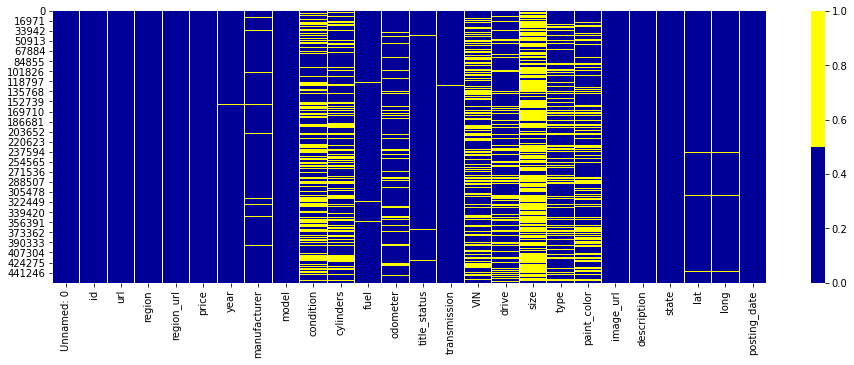

In [ ]:
# Visualising the missing values
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
cols = df.columns[:27] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
plt.figure(figsize = (16,5))
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

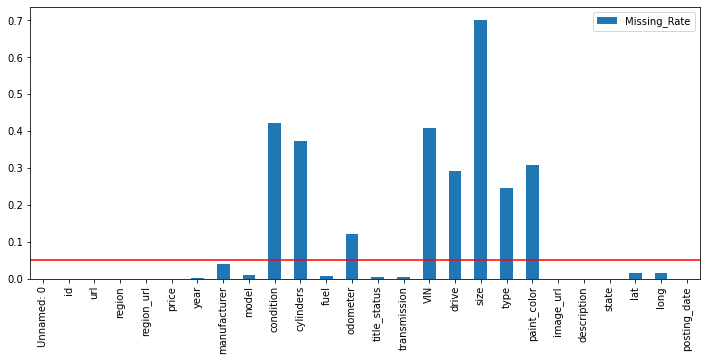

In [ ]:
#Visualising the missing values using bar graph
pd.DataFrame(df.isnull().sum()/len(df),columns=["Missing_Rate"]).plot.bar(figsize=(12,5));
plt.axhline(0.05,color="red");

## Imputing Missing Values

In [ ]:
# Sum and percentage of missing values before imputation
b1 = df['manufacturer'].isna().sum()
b2 = df['manufacturer'].isna().mean().round(4)*100
b3 = df['cylinders'].isna().sum()
b4 = df['cylinders'].isna().mean().round(4)*100
b5 = df['transmission'].isna().sum()
b6 = df['transmission'].isna().mean().round(4)*100
b7 = df['drive'].isna().sum()
b8 = df['drive'].isna().mean().round(4)*100
b9 = df['size'].isna().sum()
b10 = df['size'].isna().mean().round(4)*100
b11 = df['type'].isna().sum()
b12 = df['type'].isna().mean().round(4)*100

In [ ]:
# Function to impute missing records based on one column
def one_column_comparison(column_to_fill, column_to_compare):
    compare_values = df.iloc[df[df[column_to_fill].isnull()].index][column_to_compare].value_counts().keys()

    for value in compare_values:
        matched_value_counts = df[df[column_to_compare] == value][column_to_fill].value_counts()
        if not matched_value_counts.empty:
            value_to_fill = matched_value_counts.keys()[0]
            df.loc[(df[column_to_fill].isnull()) & (df[column_to_compare]==value), column_to_fill] = value_to_fill


In [ ]:
# Function to impute missing records based on two columns
def two_column_comparison(column_to_fill, column_to_compare1,column_to_compare2):
    grouped_output = df.loc[df[column_to_fill].isnull()][[column_to_compare1,column_to_compare2]].groupby([column_to_compare1,column_to_compare2])
    for group_name, df_group in grouped_output:
        value1,value2 = group_name[0],group_name[1]
        matched_value_counts = df[(df[column_to_compare1] == value1) & (df[column_to_compare2] == value2)][column_to_fill].value_counts()
        if not matched_value_counts.empty:
            value_to_fill = matched_value_counts.keys()[0]
            df.loc[(df[column_to_fill].isnull()) & (df[column_to_compare1]==value1) & (df[column_to_compare2]==value2), column_to_fill] = value_to_fill
   

In [ ]:
%%time
# Imputing missing values for Manufacturer
print("Missing count before imputing {}".format(df['manufacturer'].isna().sum()))
one_column_comparison('manufacturer','model')
print("Missing count after imputing {}".format(df['manufacturer'].isna().sum()))

Missing count before imputing 18220
Missing count after imputing 17423
CPU times: user 3min 51s, sys: 238 ms, total: 3min 51s
Wall time: 3min 52s


Earlier we used to have 18,220 missing values for manufacturer. After imputation it got reduced to 17,423. We have imputed 797 records.



In [ ]:
%%time
# Imputing missing values for Cyclinders
print("Missing count before imputing {}".format(df['cylinders'].isna().sum()))
two_column_comparison('cylinders','manufacturer','model')
print("Missing count after imputing {}".format(df['cylinders'].isna().sum()))

Missing count before imputing 171140
Missing count after imputing 32152
CPU times: user 20min 41s, sys: 1.8 s, total: 20min 43s
Wall time: 20min 47s


Earlier we used to have 1,71,140 missing values for cylinders. After imputation it got reduced to 32,149. We have imputed 1,38,991 records.




In [ ]:
%%time
# Imputing missing values for Size
print("Missing count before imputing {}".format(df['size'].isna().sum()))
two_column_comparison('size','manufacturer','model')
print("Missing count after imputing {}".format(df['size'].isna().sum()))

Missing count before imputing 321348
Missing count after imputing 76153
CPU times: user 30min 11s, sys: 2.31 s, total: 30min 13s
Wall time: 30min 18s


Earlier we used to have 3,21,348 missing values for size. After imputation it got reduced to 76,150. We have imputed 2,45,198 records.

In [ ]:
%%time
# Imputing missing values for Transmission
print("Missing count before imputing {}".format(df['transmission'].isna().sum()))
two_column_comparison('transmission','manufacturer','model')
print("Missing count after imputing {}".format(df['transmission'].isna().sum()))

Missing count before imputing 2442
Missing count after imputing 353
CPU times: user 1min, sys: 111 ms, total: 1min
Wall time: 1min


Earlier we used to have 2,442 missing values for transmission. After imputation it got reduced to 353. We have imputed 2,089 records.


In [ ]:
%%time
# Imputing missing values for Type
print("Missing count before imputing {}".format(df['type'].isna().sum()))
two_column_comparison('type','manufacturer','model')
print("Missing count after imputing {}".format(df['type'].isna().sum()))

Missing count before imputing 112738
Missing count after imputing 16888
CPU times: user 17min 53s, sys: 1.52 s, total: 17min 54s
Wall time: 17min 57s


Earlier we used to have 1,12,738 missing values for type. After imputation it got reduced to 16,885. We have imputed 95,853 records.


In [ ]:
%%time
# Imputing missing values for Drive
print("Missing count before imputing {}".format(df['drive'].isna().sum()))
two_column_comparison('drive','manufacturer','model')
print("Missing count after imputing {}".format(df['drive'].isna().sum()))

Missing count before imputing 134188
Missing count after imputing 23189
CPU times: user 19min 54s, sys: 1.81 s, total: 19min 55s
Wall time: 19min 59s


Earlier we used to have 1,34,188 missing values for drive. After imputation it got reduced to 23,186. We have imputed 1,11,002records.


In [ ]:
b13 = df['manufacturer'].isna().sum()
b14 = df['manufacturer'].isna().mean().round(4)*100
b15 = df['cylinders'].isna().sum()
b16 = df['cylinders'].isna().mean().round(4)*100
b17 = df['transmission'].isna().sum()
b18 = df['transmission'].isna().mean().round(4)*100
b19 = df['drive'].isna().sum()
b20 = df['drive'].isna().mean().round(4)*100
b21 = df['size'].isna().sum()
b22 = df['size'].isna().mean().round(4)*100
b23 = df['type'].isna().sum()
b24 = df['type'].isna().mean().round(4)*100

In [ ]:
# Comparision of imputations
data = {'Manufacturer': [b1, b13, b2, b14],
        'Cylinders': [b3, b15, b4, b16],
        'Transmission': [b5, b17, b6, b18],
        'Drive': [b7, b19, b8, b20],
        'Size': [b9, b21, b10, b22],
        'type': [b11, b23, b12, b24]}

In [ ]:
comparision = pd.DataFrame(data, index =['Number of missing values before imputation', 
                                'Number of missing values after imputation',
                                'Percentage of missing values before imputation',
                                'Percentage of missing values after imputation']) 
comparision

Manufacturer  ...       type
Number of missing values before imputation          18220.00  ...  112738.00
Number of missing values after imputation           17423.00  ...   16883.00
Percentage of missing values before imputation          3.98  ...      24.60
Percentage of missing values after imputation           3.80  ...       3.68

[4 rows x 6 columns]

In [ ]:
df.isnull().sum() * 100 / len(df)

Unnamed: 0       0.000000
id               0.000000
url              0.000000
region           0.000000
region_url       0.000000
price            0.000000
year             0.229151
manufacturer     3.802380
model            1.057587
condition       42.107055
cylinders        7.015733
fuel             0.706440
odometer        12.069278
title_status     0.562402
transmission     0.077038
VIN             40.930528
drive            5.059656
size            16.618472
type             3.684531
paint_color     30.737452
image_url        0.006111
description      0.015277
state            0.000000
lat              1.625445
long             1.625445
posting_date     0.006111
dtype: float64

In [ ]:
#Shape of dataframe before dropping any columns
df.shape

(458213, 26)

In [ ]:
# Exporting the missing values imputed dataset
df.to_csv("vehicles_db1.csv")

## **New columns**

In [10]:
df= pd.read_csv("vehicles_db1.csv", index_col= 0)
df.drop(df.filter(regex="Unnamed"),axis=1, inplace=True)

In [12]:
# Extracting age of the vehicle using year
df = df[df.year.notnull()]
df["vehicle_age"] = df.year.apply(lambda x: int(2021-x))
df["vehicle_age"]

0         11
1          7
2         15
3         47
4         16
          ..
458208     7
458209     3
458210     7
458211    13
458212    13
Name: vehicle_age, Length: 457163, dtype: int64

In [13]:
# EXTRACTING age_of_ad using posting date
import datetime
from datetime import datetime
df = df.dropna(subset=['posting_date'])
df['posting_date'] = pd.to_datetime(df['posting_date'], utc = True)
df['Year_month_date'] = pd.to_datetime(df['posting_date']).dt.to_period('D')
df['Year_month_date'] = df['Year_month_date'].dt.to_timestamp('d')
now = datetime.now()
df['age_of_ad'] = now - df['Year_month_date']
df['age_of_ad'] = df['age_of_ad'].dt.days
df['age_of_ad'].head(10)                                                            

0    125
1    125
2    125
3    126
4    126
5    126
6    127
7    128
8    129
9    130
Name: age_of_ad, dtype: int64

In [14]:
# Renaming the columns for better understanding
df.rename (columns={'vehicle_age': 'vehicle_age_in_years', 'age_of_ad': 'age_of_ad_in_days'}, inplace= True)

In [15]:
df.shape

(457163, 28)

## **Data Correction**

In [16]:
# Data correction in Drive column
df['drive'].replace({'4wd':'fwd'}, inplace=True)

There are few records where the customers entered the data as "Others". Here, we are trying to impute those records based on the previous observations

In [17]:
# Function to correct the data based on two columns
def fill_value_other(column_to_fill, column_to_compare1,column_to_compare2):
    grouped_output = df.loc[df[column_to_fill]=='other'][[column_to_compare1,column_to_compare2]].groupby([column_to_compare1,column_to_compare2])
    for group_name, df_group in grouped_output:
        value1,value2 = group_name[0],group_name[1]
        matched_value_counts = df[(df[column_to_compare1] == value1) & (df[column_to_compare2] == value2)][column_to_fill].value_counts()
        if not matched_value_counts.empty:
            value_to_fill = matched_value_counts.keys()[0]
            df.loc[(df[column_to_fill]=='other') & (df[column_to_compare1]==value1) & (df[column_to_compare2]==value2), column_to_fill] = value_to_fill
   

In [18]:
df.cylinders.unique()

array(['8 cylinders', '4 cylinders', '6 cylinders', nan, 'other',
       '10 cylinders', '5 cylinders', '3 cylinders', '12 cylinders'],
      dtype=object)

Few customers might have no knowledge about the number of cylinders present in their vehicle and entered it as "others" while entering the vehicle details. We can get the correct value of the cylinders by observing the previous records.

In [19]:
%%time
# Changing values named "other" in Cyclinders feature
print("Count before changing value other {}".format(len(df[df['cylinders']=='other'])))
fill_value_other('cylinders','manufacturer','model')
print("Count after changing value other {}".format(len(df[df['cylinders']=='other'])))

Count before changing value other 2234
Count after changing value other 1795
CPU times: user 56 s, sys: 158 ms, total: 56.2 s
Wall time: 56.2 s


We have corrected the data for 440 records

In [20]:
# Stripping the word cylinder and converting the datatype
df['cylinders'] = df['cylinders'].str.replace('cylinders','')
df['cylinders'] = df['cylinders'].convert_dtypes()
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

In [21]:
# Dropping the null values and converting the datatyoe to int
df.dropna(axis=0, subset=['cylinders'], inplace=True)
df['cylinders'] = df['cylinders'].astype(int)

In [22]:
df.fuel.unique()

array(['gas', 'diesel', 'other', 'hybrid', nan, 'electric'], dtype=object)

Similarly, by observing the previous records we can correct the data field named "other" for fuel as well.

In [23]:
%%time
# Changing values named "other" in Fuel feature
print("Count before changing value other {}".format(len(df[df['fuel']=='other'])))
fill_value_other('fuel','manufacturer','model')
print("Count after changing value other {}".format(len(df[df['fuel']=='other'])))

Count before changing value other 14569
Count after changing value other 2375
CPU times: user 3min 45s, sys: 828 ms, total: 3min 46s
Wall time: 3min 46s


We have corrected the data for 12,195 records

In [24]:
df.transmission.unique()

array(['other', 'automatic', 'manual', nan], dtype=object)

In [25]:
%%time
# Changing values named "other" in transmission feature
print("Count before changing value other {}".format(len(df[df['transmission']=='other'])))
fill_value_other('transmission','manufacturer','model')
print("Count after changing value other {}".format(len(df[df['transmission']=='other'])))

Count before changing value other 25343
Count after changing value other 17934
CPU times: user 3min 11s, sys: 677 ms, total: 3min 12s
Wall time: 3min 12s


We have corrected the data for 7,594 records

In [26]:
df['type'].unique()

array(['other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', 'truck',
       'mini-van', 'wagon', 'convertible', 'hatchback', nan, 'offroad',
       'bus'], dtype=object)

In [27]:
%%time
# Changing values named "other" in type feature
print("Count before changing value other {}".format(len(df[df['type']=='other'])))
fill_value_other('type','manufacturer','model')
print("Count after changing value other {}".format(len(df[df['type']=='other'])))

Count before changing value other 21337
Count after changing value other 10704
CPU times: user 3min 53s, sys: 813 ms, total: 3min 54s
Wall time: 3min 54s


We have corrected the data for 10,737 records

## **Removing Unwanted Columns**

In [28]:
#Shape of dataframe before dropping columns
df.shape

(423262, 28)

In [40]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'vehicle_age_in_years', 'Year_month_date', 'age_of_ad_in_days'],
      dtype='object')

In [29]:
# Drop unwanted columns
columns_to_drop = ['id', 'url', 'region_url', 'image_url', 'description', 'VIN', 'lat', 'long','posting_date', 'Year_month_date']
df = df.drop(columns_to_drop, axis = 1)
df.head(5)

region  price    year  ... state vehicle_age_in_years age_of_ad_in_days
0  auburn  35990  2010.0  ...    al                   11               125
1  auburn   7500  2014.0  ...    al                    7               125
2  auburn   4900  2006.0  ...    al                   15               125
3  auburn   2000  1974.0  ...    al                   47               126
4  auburn  19500  2005.0  ...    al                   16               126

[5 rows x 18 columns]

## **Removing rows having atleast one null value**

In [30]:
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'vehicle_age_in_years',
       'age_of_ad_in_days'],
      dtype='object')

In [31]:
# dropping rows which are having atleast one null value
df.dropna(axis=0, subset=['paint_color','drive','type','size',
                          'manufacturer','year','model','fuel',
                          'title_status','transmission',
                          'title_status', 'condition', 'cylinders'], inplace=True)

Now, we have imputed the missing values, extracted new columns, removed existing columns, corrected the data and removed all the rows having atleast one null values other than odometer.

In [32]:
# shape of dataframe
df.shape

(173731, 18)

In [35]:
df.to_csv("vehicles_db2.csv", index = False)

odometer is a column which is having null values and the datatype of the feature is numeric. We are going to impute values using KNN imputer. To perform KNN imputation, we need to encode the categorical variables and then scale the data. 

1. Here, we are choosing ordinal encoding for "Condition" feature and Target encoding the rest of the features.
2. To implement target encoding, the target feature "Price" should not contain the extreme values and zeros. But, It can have outliers.
3. The same applies for odometer feature as well. We need to remove the extreme values before encoding, scaling and imputation.

In [36]:
df['odometer'].isnull().sum()

13101

## **Refining Price**



In [11]:
%%time
# Reading the dataset
df=pd.read_csv('vehicles_db2.csv')

CPU times: user 331 ms, sys: 52.3 ms, total: 383 ms
Wall time: 408 ms


In [12]:
#Importing the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

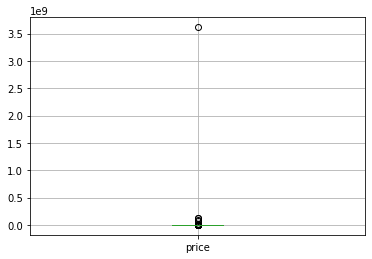

In [13]:
# Initial visualisation of price feature using boxplot
df.boxplot('price')

Due to extreme values, we are unable to see the data distribution in box plot. As an alternative we will try distribution plot.

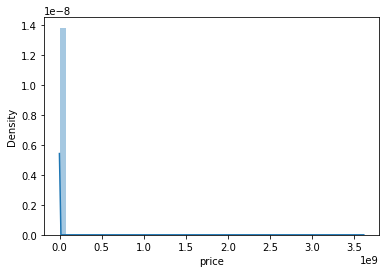

In [14]:
# Initial visualization of price feature using distinct plot
sns.distplot(df.price)

Even in distribution plot, we are unable to view the data distribution. We need to remove the extremist outliers to get the visualization

In [15]:
# Finding the minimum and maximum price
df.price.min(), df.price.max()

(0, 3615215112)

In [16]:
# Removing rows which are having price as zero
df = df[df['price']>0]

In [17]:
# Removed few outliers manually to visualise the actual distribution
#3615215112, 123456789, 98504250,79000000,22000000,12345678,7900000,1234567,
#1111111,384995,345000,301999,301999,279888,235000,234567,229999,219995,
#205000,198750,192500,189998.

In [18]:
# removing price which is an outlier
df = df[df['price']<189998]

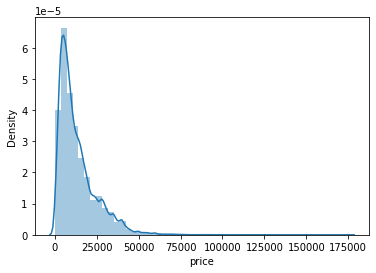

In [19]:
sns.distplot(df.price)

We got a better visuality compared to previous plots. From the graph, we can see that the data is spread in between zero and 50,000.

In [20]:
df = df[df['price']<50000]

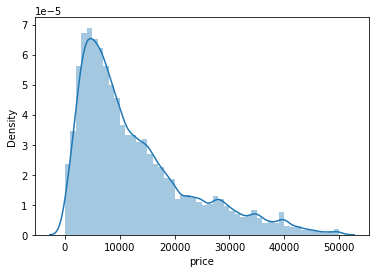

In [21]:
sns.distplot(df.price)

By viewing the above plot, we can conclude that all of the vehicles are priced in the range of 2000 to 50,000. To get better understanding lets plot the IQR

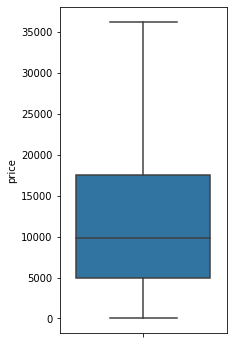

In [22]:
# Plotting the IQR for price distribution
plt.figure(figsize=(3,6))
sns.boxplot(y='price', data=df,showfliers=False);

In [23]:
# Finding the minimum and maximum price
df.price.min(), df.price.max()

(1, 49999)

## **Refining Odometer**


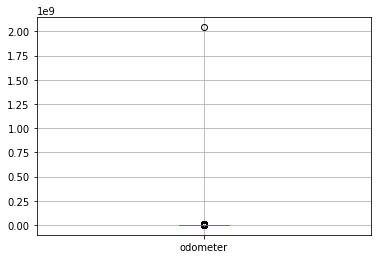

In [24]:
# Initial visualisation of odometer feature using boxplot
df.boxplot('odometer')

The odometer also contains extreme values and we are unable to visualise the data distribution.

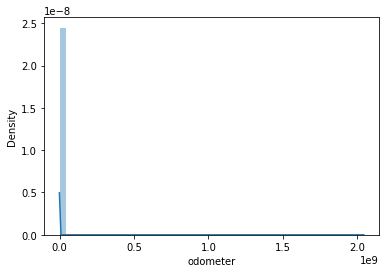

In [25]:
# Initial visualization of odometer feature using distinct plot
sns.distplot(df.odometer)

Even in the distribution plot, we are unable to view the spread of the data.

In [26]:
# Finding the minimum and maximum odometer values
df.odometer.min(), df.odometer.max()

(0.0, 2043755555.0)

In [27]:
# Finding the number of null values
df['odometer'].isnull().sum()

11813

In [28]:
# Assigning the null values to another dataframe
df1 = df.loc[pd.isnull(df[['odometer']]).any(axis=1)]

In [29]:
#Replacing null values with integer
df1['odometer'] = df1['odometer'].fillna(-1)

In [30]:
# Removing rows which are having odometer as zero
df = df[df['odometer']>0]

In [31]:
# removing rows which are having extreme values in odometer
df = df[df['odometer']<300000.0]

In [32]:
# Merging two dataframes
df = pd.merge_ordered(df1, df)

In [33]:
# Replacing integers back to null values
df['odometer'] = df['odometer'].replace(-1.0, np.nan)

In [34]:
df.odometer.isnull().sum()

11813

In [35]:
df.odometer.min(), df.odometer.max()

(1.0, 299999.0)

Now, we have got the odometer values in range between one and one lakh and it includes null values which are to be imputed using KNN imputer. It includes the outliers as well. We are just correcting the data distribution by removing extreme values.

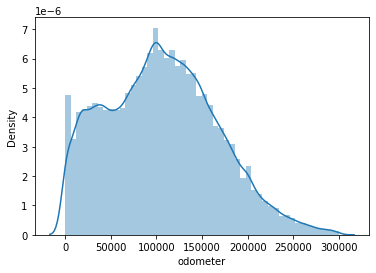

In [36]:
sns.distplot(df['odometer'])

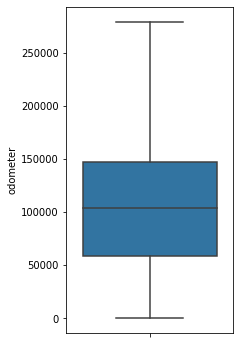

In [37]:
# Plotting the IQR for price distribution
plt.figure(figsize=(3,6))
sns.boxplot(y='odometer', data=df,showfliers=False);

In [38]:
# The shape of the dataframe after removing the extreme values from price and odometer
df.shape

(162727, 18)

In [42]:
# Exporting the dataset
df.to_csv('vehicles_db3.csv', index = False)

In [40]:
df['odometer'].isnull().sum()

11813

## **Target Encoding**

In [57]:
df = pd.read_csv("vehicles_db3.csv", index_col = False)

Converting the categorical columns in to numerical values using Target Encoding.

In [58]:
# Function for Target Encoding
def create_encoded_categorical_columns(vehicles_dataframe, target_column, categorical_columns):
    from category_encoders import TargetEncoder
    for categorical_column in categorical_columns: 
        print ("CT_Col :",categorical_column)
        encoder = TargetEncoder()
        vehicles_dataframe[categorical_column+"_encoded"] = encoder.fit_transform(vehicles_dataframe[categorical_column], 
                                                                                  vehicles_dataframe[target_column])
    return vehicles_dataframe

In [59]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)


In [60]:
%%time
#Convert categorical columns to numerical values using target encoder
categorical_columns = ['region', 'manufacturer', 'model', 'fuel', 'title_status', 
                       'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
target_column = 'price'
categorical_encoded_columns = create_encoded_categorical_columns(df, target_column, categorical_columns)
target_encoded_db = categorical_encoded_columns.drop(categorical_columns, axis=1)

CT_Col : region
CT_Col : manufacturer
CT_Col : model
CT_Col : fuel
CT_Col : title_status
CT_Col : transmission
CT_Col : drive
CT_Col : size
CT_Col : type
CT_Col : paint_color
CT_Col : state
CPU times: user 1.06 s, sys: 27 ms, total: 1.08 s
Wall time: 1.08 s


In [61]:
# Datatype of each feature
target_encoded_db.dtypes

price                     int64
year                    float64
condition                object
cylinders                 int64
odometer                float64
vehicle_age_in_years      int64
age_of_ad_in_days         int64
region_encoded          float64
manufacturer_encoded    float64
model_encoded           float64
fuel_encoded            float64
title_status_encoded    float64
transmission_encoded    float64
drive_encoded           float64
size_encoded            float64
type_encoded            float64
paint_color_encoded     float64
state_encoded           float64
dtype: object

In [62]:
target_encoded_db.head(5)

price    year  condition  ...  type_encoded  paint_color_encoded  state_encoded
0      1  1995.0       fair  ...  10101.961977          8495.284496   13782.033541
1    155  2010.0       good  ...   8555.079136         10920.299449   13782.033541
2    183  2012.0  excellent  ...  12317.415029         15014.963544   13782.033541
3    365  2017.0  excellent  ...   8555.079136         10920.299449   13782.033541
4    395  2016.0  excellent  ...  12317.415029         10920.299449   13782.033541

[5 rows x 18 columns]

## **Ordinal Encoding**

In [63]:
target_encoded_db['condition'].unique()

array(['fair', 'good', 'excellent', 'like new', 'salvage', 'new'],
      dtype=object)

In [64]:
categories = pd.Categorical(target_encoded_db['condition'], categories=['salvage', 'fair', 'good', 'excellent', 'like new', 'new'], 
                            ordered=True)

In [65]:
labels, unique = pd.factorize(categories, sort=True)
target_encoded_db['condition'] = labels

In [66]:
target_encoded_db.head()

price    year  condition  ...  type_encoded  paint_color_encoded  state_encoded
0      1  1995.0          1  ...  10101.961977          8495.284496   13782.033541
1    155  2010.0          2  ...   8555.079136         10920.299449   13782.033541
2    183  2012.0          3  ...  12317.415029         15014.963544   13782.033541
3    365  2017.0          3  ...   8555.079136         10920.299449   13782.033541
4    395  2016.0          3  ...  12317.415029         10920.299449   13782.033541

[5 rows x 18 columns]

In [68]:
target_encoded_db.isnull().sum()

price                       0
year                        0
condition                   0
cylinders                   0
odometer                11813
vehicle_age_in_years        0
age_of_ad_in_days           0
region_encoded              0
manufacturer_encoded        0
model_encoded               0
fuel_encoded                0
title_status_encoded        0
transmission_encoded        0
drive_encoded               0
size_encoded                0
type_encoded                0
paint_color_encoded         0
state_encoded               0
dtype: int64

## **Scaling the features**

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_db = pd.DataFrame(scaler.fit_transform(target_encoded_db), columns = target_encoded_db.columns)
scaled_db.head()

price      year  ...  paint_color_encoded  state_encoded
0  0.00000  0.745098  ...             0.000000       0.335611
1  0.00308  0.892157  ...             0.371953       0.335611
2  0.00364  0.911765  ...             1.000000       0.335611
3  0.00728  0.960784  ...             0.371953       0.335611
4  0.00788  0.950980  ...             0.371953       0.335611

[5 rows x 18 columns]

In [70]:
scaled_db['odometer'].isnull().sum()

11813

In [71]:
scaled_db.shape

(162727, 18)

In [72]:
scaled_db.columns

Index(['price', 'year', 'condition', 'cylinders', 'odometer',
       'vehicle_age_in_years', 'age_of_ad_in_days', 'region_encoded',
       'manufacturer_encoded', 'model_encoded', 'fuel_encoded',
       'title_status_encoded', 'transmission_encoded', 'drive_encoded',
       'size_encoded', 'type_encoded', 'paint_color_encoded', 'state_encoded'],
      dtype='object')

## **KNN Imputation**

In [73]:
%%time
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputed_db = pd.DataFrame(imputer.fit_transform(scaled_db),columns = scaled_db.columns)

CPU times: user 2min 49s, sys: 6.95 s, total: 2min 56s
Wall time: 2min 38s


In [74]:
imputed_db.odometer.isnull().sum()

0

In [75]:
imputed_db.head()

price      year  ...  paint_color_encoded  state_encoded
0  0.00000  0.745098  ...             0.000000       0.335611
1  0.00308  0.892157  ...             0.371953       0.335611
2  0.00364  0.911765  ...             1.000000       0.335611
3  0.00728  0.960784  ...             0.371953       0.335611
4  0.00788  0.950980  ...             0.371953       0.335611

[5 rows x 18 columns]

Applying logarithmic transformation for odometer feature to change the distribution

In [76]:
df['odometer'] = np.log2(df['odometer'])

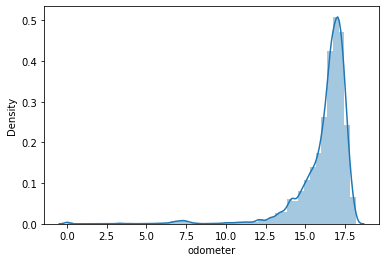

In [77]:
sns.distplot(df['odometer'])

In [78]:
# Exporting the dataset
imputed_db.to_csv("vehicles_db4.csv",index=False)

vehicles_db4.csv is the dataset which contains outliers and we will be considering this as base to prepare another three datasets.

## **DBscan Outliers removal**

Estimated number of clusters: 92
Estimated number of noise points: 2833
Silhouette Coefficient: 0.002


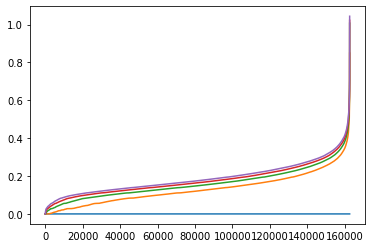

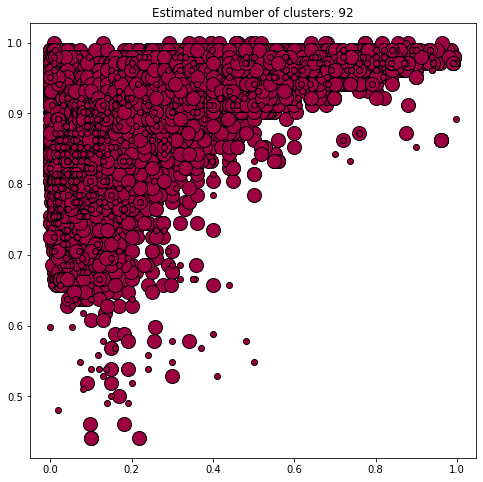

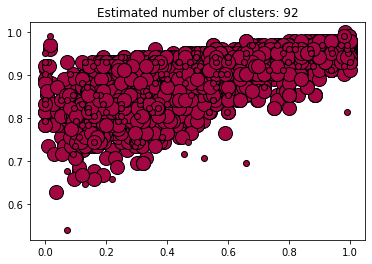

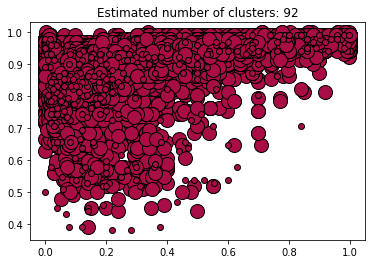

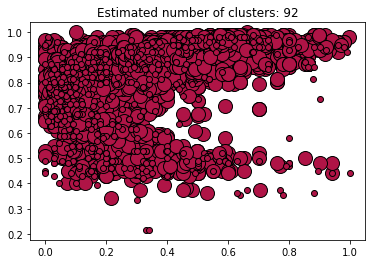

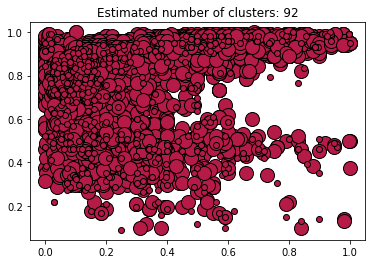

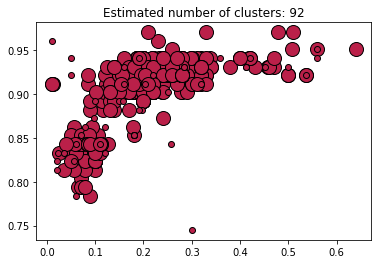

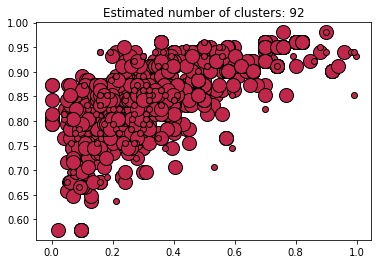

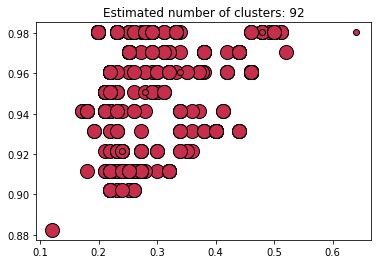

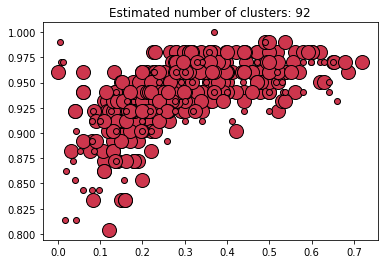

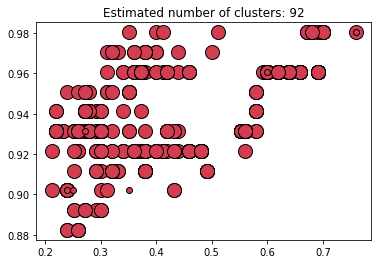

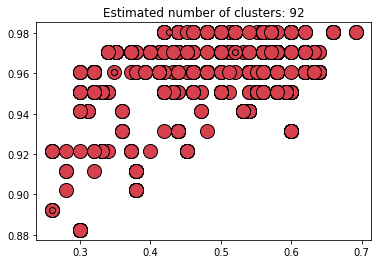

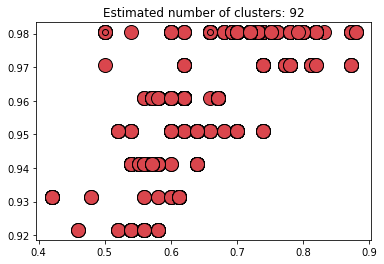

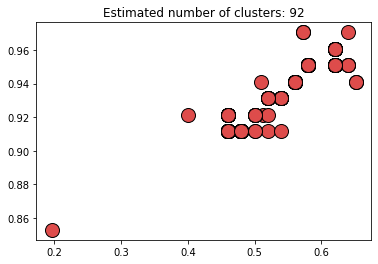

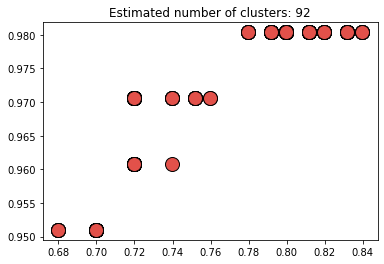

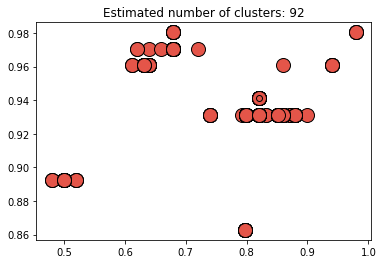

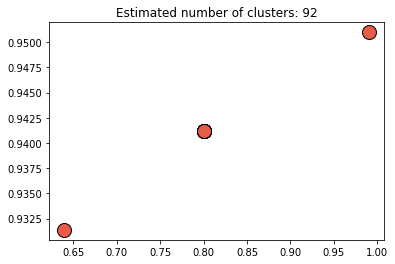

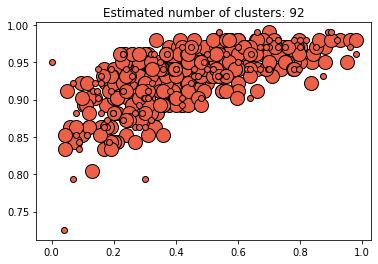

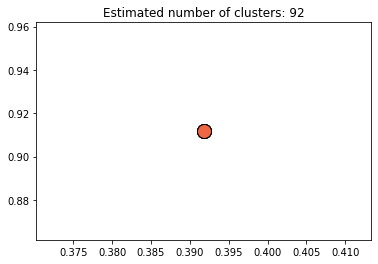

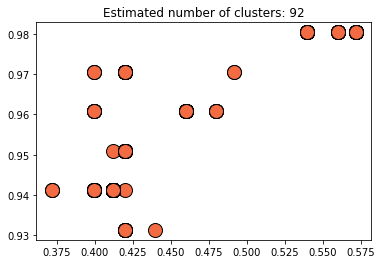

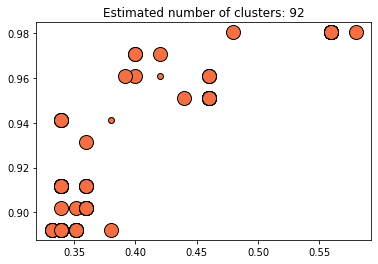

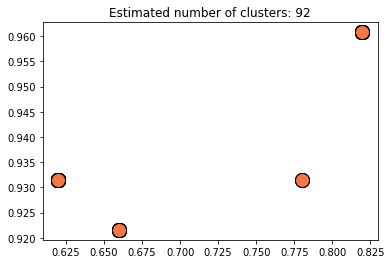

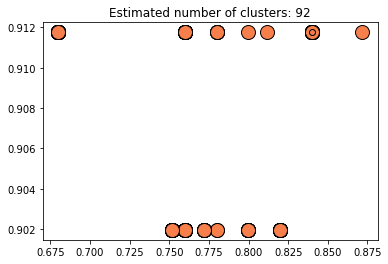

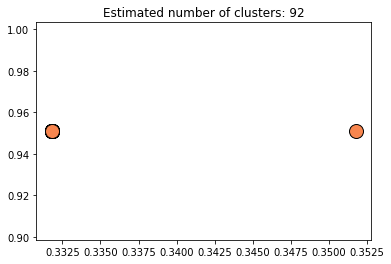

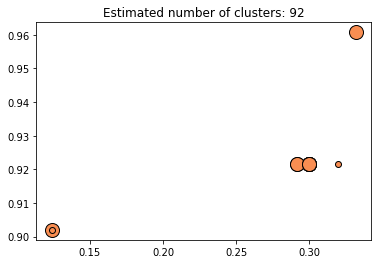

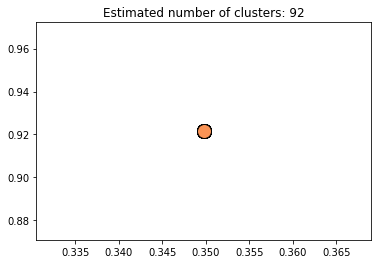

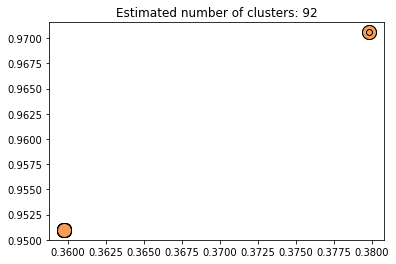

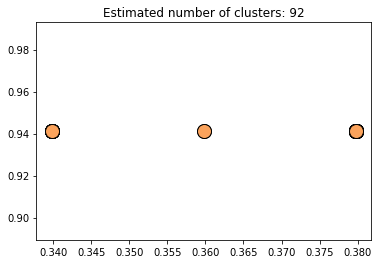

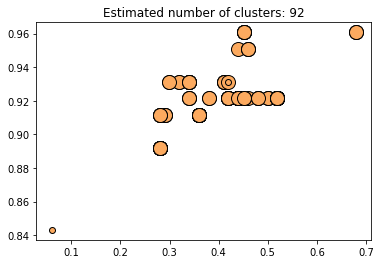

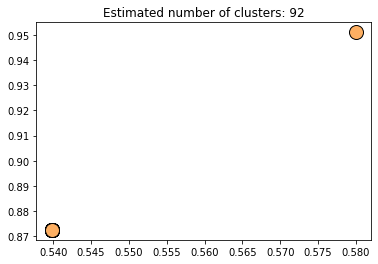

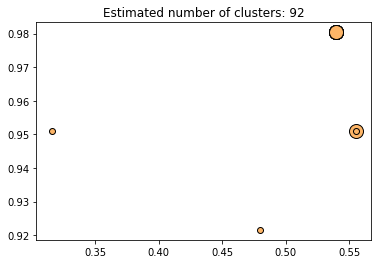

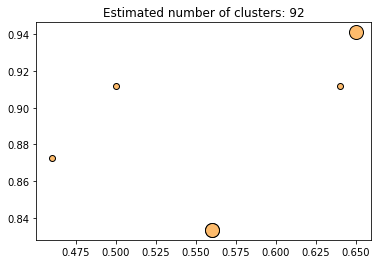

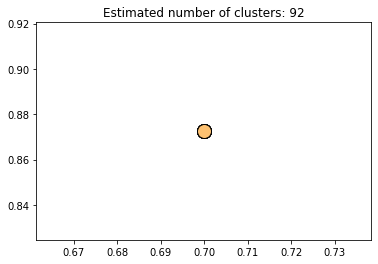

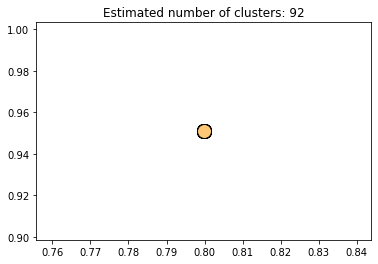

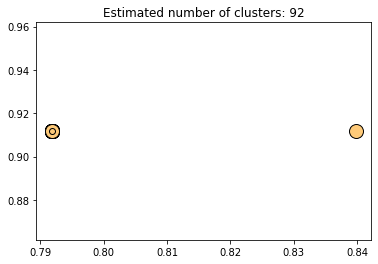

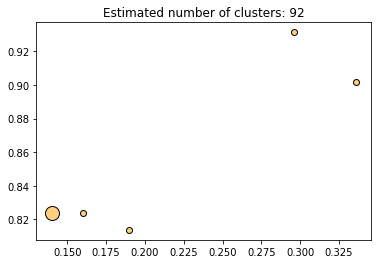

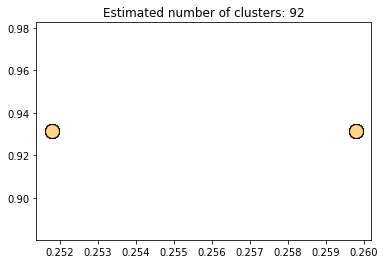

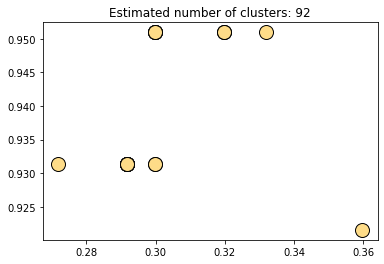

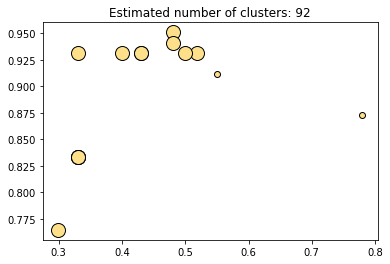

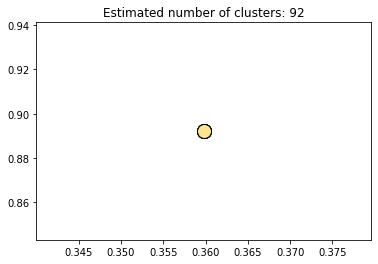

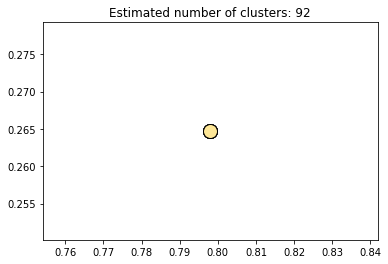

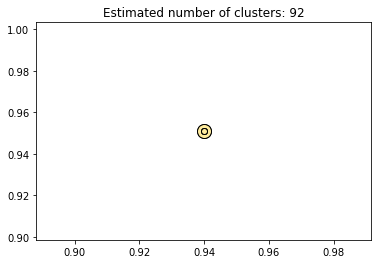

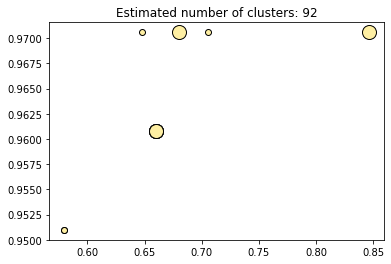

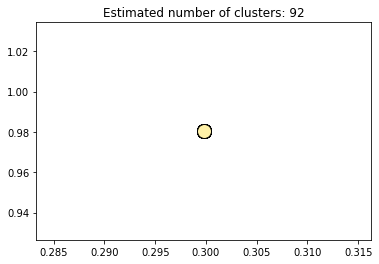

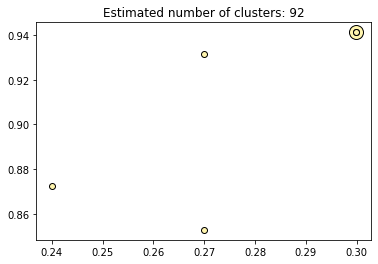

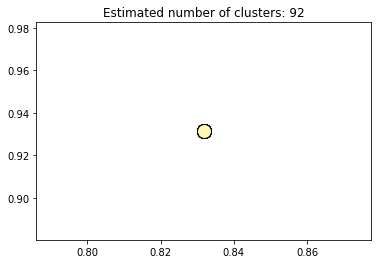

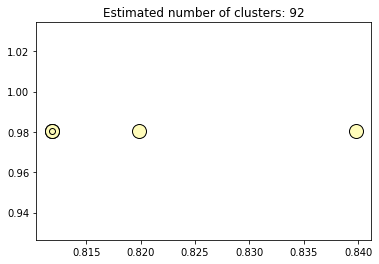

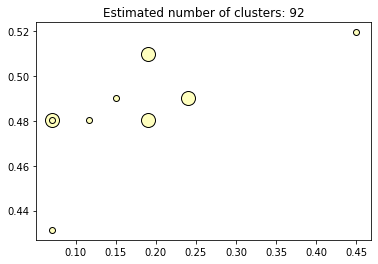

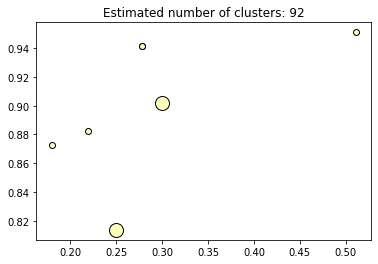

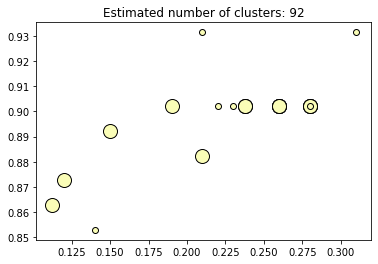

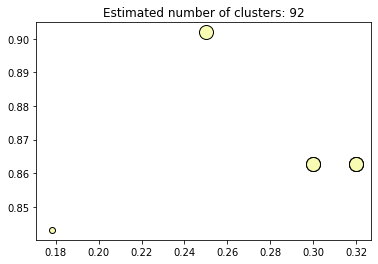

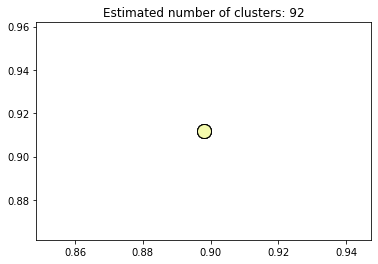

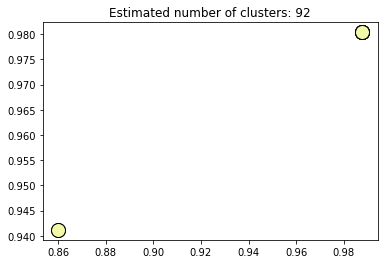

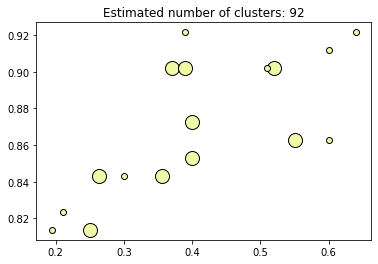

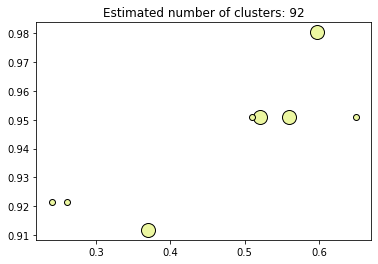

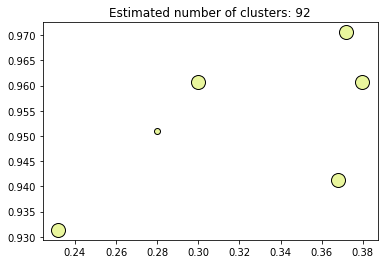

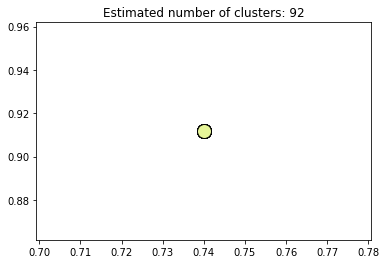

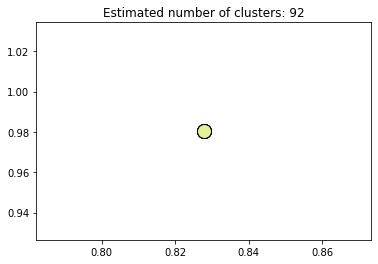

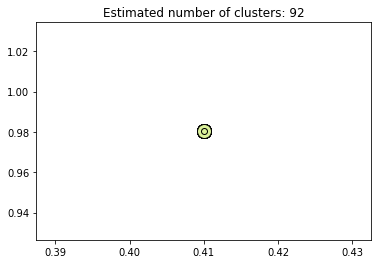

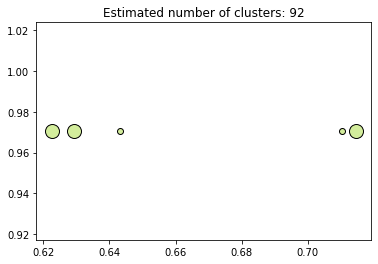

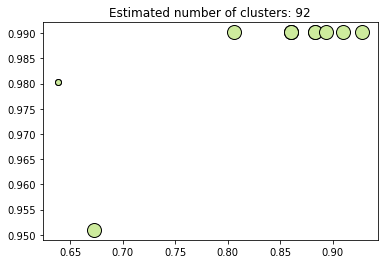

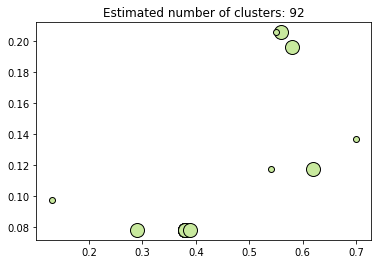

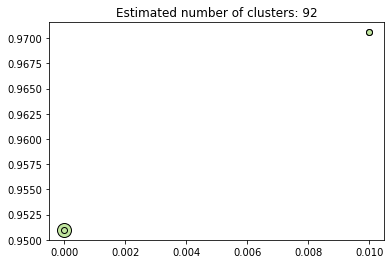

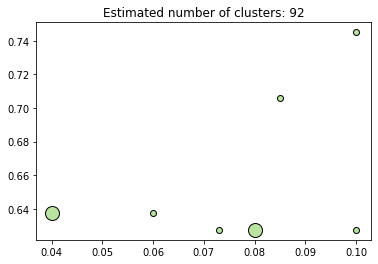

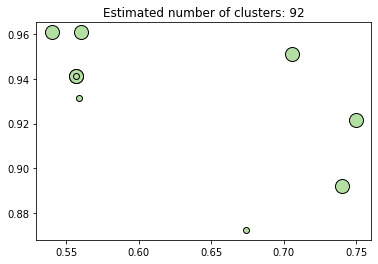

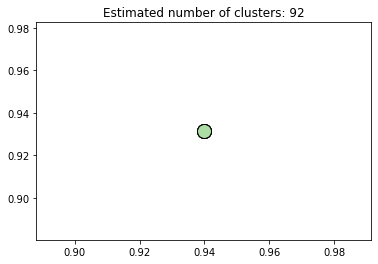

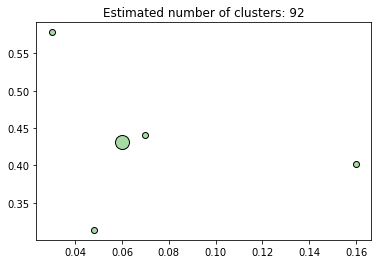

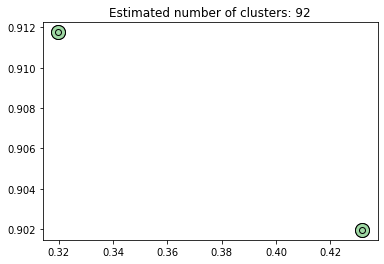

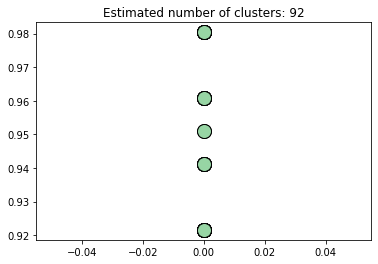

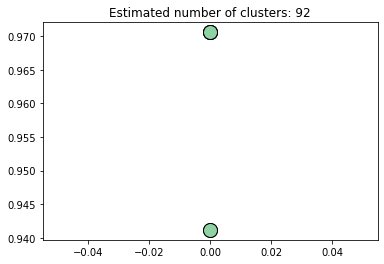

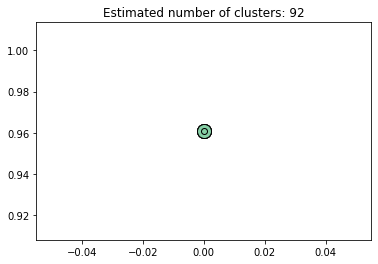

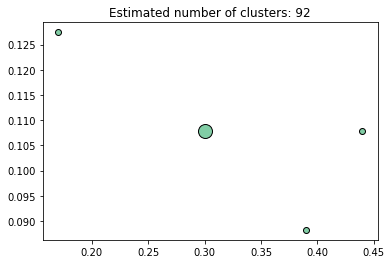

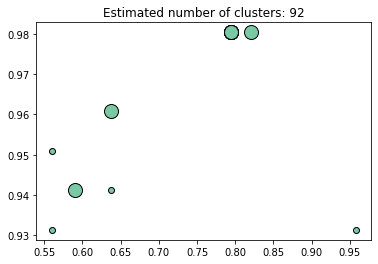

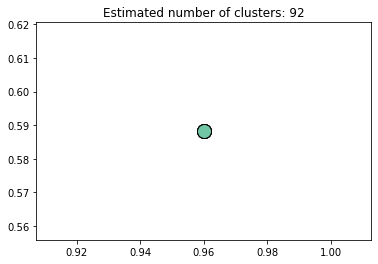

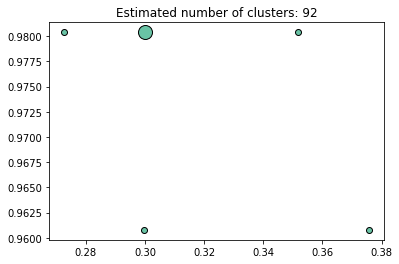

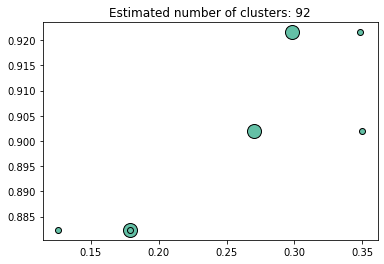

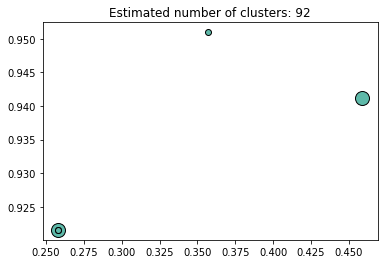

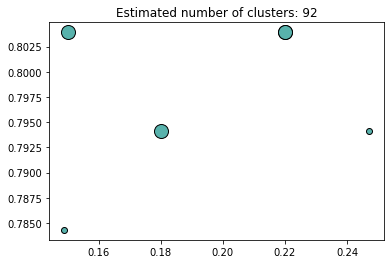

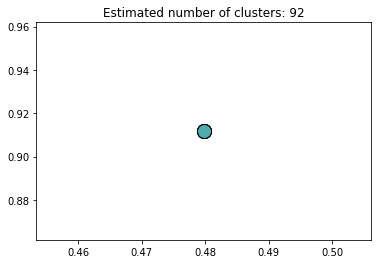

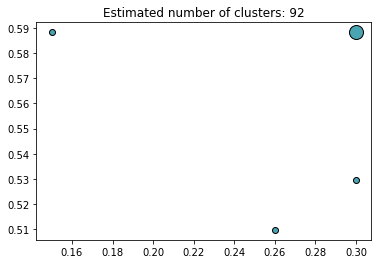

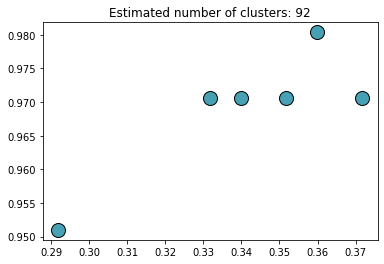

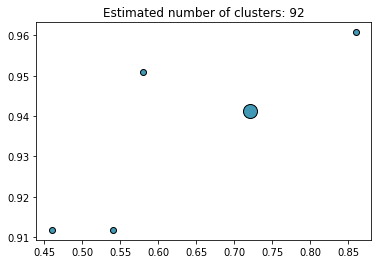

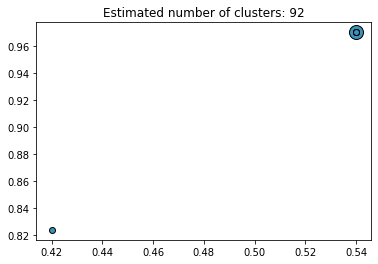

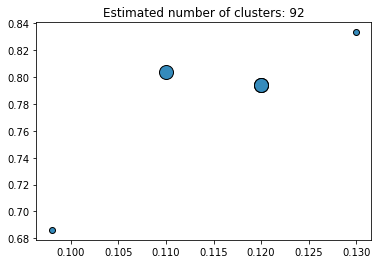

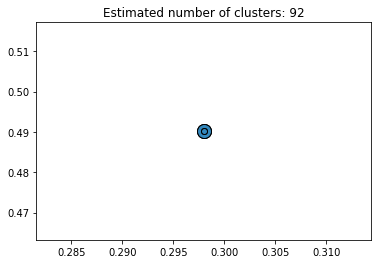

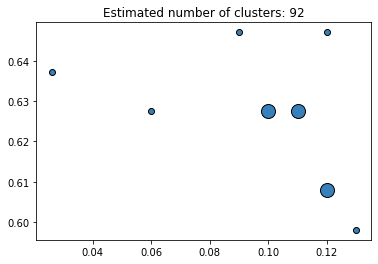

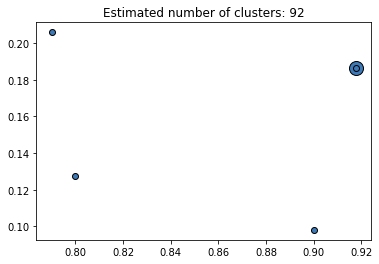

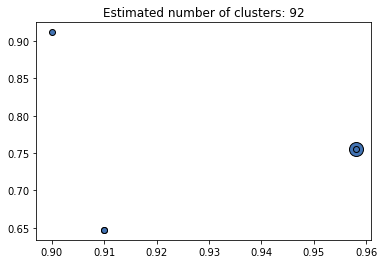

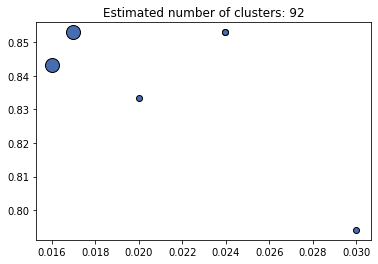

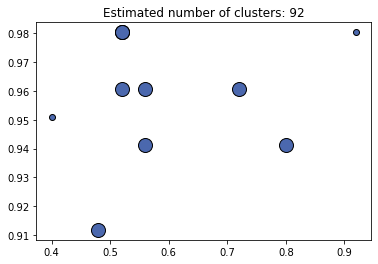

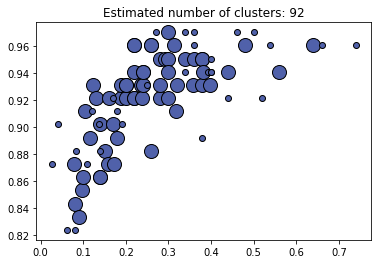

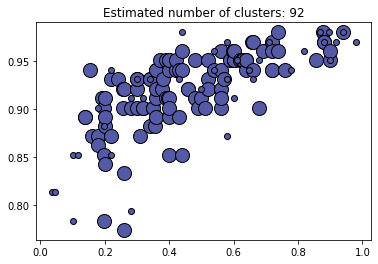

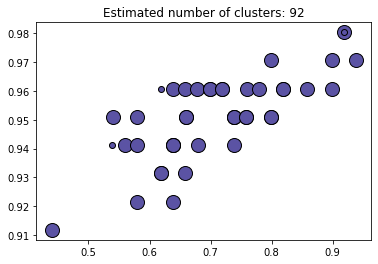

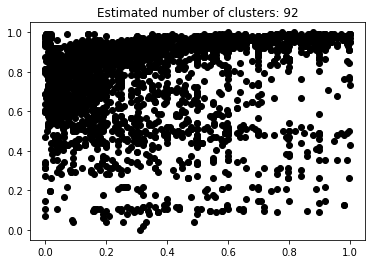

CPU times: user 22min 45s, sys: 26.3 s, total: 23min 11s
Wall time: 21min 41s


In [80]:
%%time
def findDBScanEPS(data, n_neighbors):
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = nn.fit(data)
    distances, indices = nbrs.kneighbors(data)

    distances = np.sort(distances, axis=0)
#     distances = distances[:, 1]
    plt.plot(distances)


def DBScanOutlier(data): # DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import DBSCAN
    
    d1 = data.copy()

    #scaler = MinMaxScaler()
    #d2 = scaler.fit_transform(d1)

    d2 = d1
    d2 = pd.DataFrame(d2, columns=d1.columns)

    findDBScanEPS(d2, 5)
    
    # epsfloat, default=0.5
    # The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    # This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN
    # parameter to choose appropriately for your data set and distance function.
    # min_samplesint, default=5
    # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
    # This includes the point itself.
    db = DBSCAN(eps=0.37, min_samples=5).fit(d2)
    
    from sklearn import metrics
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_



    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(d2, labels))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
    for each in np.linspace(0, 1, len(unique_labels))]
    plt.figure(figsize=(8, 8))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = d2[class_member_mask & core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = d2[class_member_mask & ~core_samples_mask]
        plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()

    #cmap = cm.get_cmap('Set1')
    #d2.plot.scatter(x='avgDeathsPerYear', y='avgAnnCount', c=clusters, cmap=cmap, colorbar=False)
    #plt.close()
    outlierRow = []
    for i in range(len(labels)):
        if (labels[i] == -1):
            #print(list((i, labels[i])))
            outlierRow.append(i)

    return outlierRow

outlierRow = DBScanOutlier(imputed_db)

In [81]:
# number of outlier rows
len(outlierRow)

2833

In [82]:
# Shape of dataframe before removing outliers
imputed_db.shape

(162727, 18)

In [83]:
#Shape of dataframe after removing outliers using DBScan
refined_db = imputed_db.drop(outlierRow)
refined_db.shape

(159894, 18)

In [84]:
refined_db.to_csv("vehicles_db5.csv")

vehicles

## **Z-Score outliers removal**

In [87]:
def zScoreOutlier(data):
    from scipy import stats
    zScore = np.abs(stats.zscore(data))
    print(np.where(zScore > 1.5))
    outlierData = data[(zScore < 1.5).all(axis=1)]
    return outlierData

imputed_db = pd.read_csv("vehicles_db4.csv")
outlierData = zScoreOutlier(imputed_db)
outlierData.shape

(array([     0,      0,      0, ..., 162726, 162726, 162726]), array([ 1,  2,  4, ...,  9, 13, 17]))


(47214, 18)

In [88]:
#Shape of dataframe after removing outliers using zScore
outlierData.shape

(47214, 18)

In [89]:
imputed_db.head()

price      year  ...  paint_color_encoded  state_encoded
0  0.00000  0.745098  ...             0.000000       0.335611
1  0.00308  0.892157  ...             0.371953       0.335611
2  0.00364  0.911765  ...             1.000000       0.335611
3  0.00728  0.960784  ...             0.371953       0.335611
4  0.00788  0.950980  ...             0.371953       0.335611

[5 rows x 18 columns]

In [90]:
zscore_db = pd.merge(imputed_db, outlierData, how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)
    
zscore_db.to_csv("vehicles_db6.csv")

In [91]:
zscore_db.shape

(115513, 18)

## **PCA** 

In [ ]:
class PCA:
    def createPCA(self, data, response):
        try:
            targetDF = data[[response]]
            uniqueTarget = targetDF[response].unique()
            # d1 = data.drop(categoricalCols, axis=1)
            d1 = data.drop(response, axis=1)
            #d1 = pd.get_dummies(d1)
            # d1=data.copy()
            scaledData = self.scaleData(d1)

            pca, pcaModel, pcaTransformed = self.performPCA(scaledData)
            self.drawScreePlot(pca, pcaTransformed.columns)
            pcaTransformedResponse = pd.concat([pcaTransformed, targetDF], axis=1)
            pcaTransformedResponse

            self.drawGraph(pcaTransformedResponse, response, uniqueTarget)
            self.showVariance(pcaModel, pca)
            return pcaTransformedResponse
        except Exception as exp:
            self.errObj = ErrorHandler()
            err = self.errObj.handleErr(str(exp))
            print(str(err))
            
    def performPCA(self, data):
        try:
            pca = PCA()  # n_components=10
            # pca = SparsePCA()
            pcaModel = pca.fit(data)
            pcaTransformed = pd.DataFrame(pcaModel.transform(data), columns=range(data.shape[1]))
            for i in range(len(pcaTransformed.columns)):
                pcaTransformed.rename(columns={i: 'PCA' + str(i)}, inplace=True)
            print(pcaTransformed.head(10))
            comp = pd.DataFrame(pcaModel.components_, columns=data.columns)
            print(comp)
            return pca, pcaModel, pcaTransformed
        except Exception as exp:
            self.errObj = ErrorHandler()
            err = self.errObj.handleErr(str(exp))
            print(str(err))

In [ ]:
pca = PCA()
pca.createPCA(df,'price')

# **Binning and Outliers removal**

In [ ]:
# Adaptive binning - Quantile based
def createBin(data, numericCol):
    import matplotlib.pyplot as plt
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = data[numericCol].quantile(quantile_list)
    # Plot the graph based on quantile findings
    fig, ax = plt.subplots()
    data[numericCol].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title(numericCol+' Histogram with Quantiles', 
                 fontsize=12)
    ax.set_xlabel(numericCol, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    # Create binned range and label column, which will help us in future
    # to divide the dataset based on binning and build suitable models
    quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
    data[numericCol+'_bin_range'] = pd.qcut(
                                                data[numericCol], 
                                                q=quantile_list)
    data[numericCol+'_bin_label'] = pd.qcut(
                                                data[numericCol], 
                                                q=quantile_list,       
                                                labels=quantile_labels)
    return data

price  ...  vehicle_age_in_years_bin_label
10  27500  ...                          25-50Q
14   4900  ...                         75-100Q
16  33990  ...                          25-50Q
17   2650  ...                         75-100Q
18  32990  ...                           0-25Q

[5 rows x 4 columns]

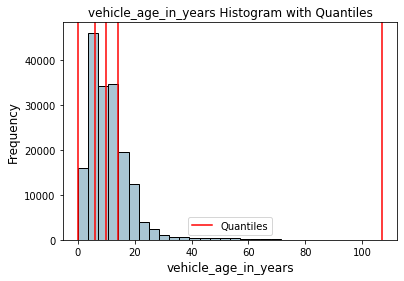

In [ ]:
#Create bin based on vechicle age, So that we can create seperate model for each bin
vehicle_binned_db = createBin(df, 'vehicle_age_in_years')
vehicle_binned_db[['price', 'vehicle_age_in_years', 'vehicle_age_in_years_bin_range', 
               'vehicle_age_in_years_bin_label']].iloc[4:9]

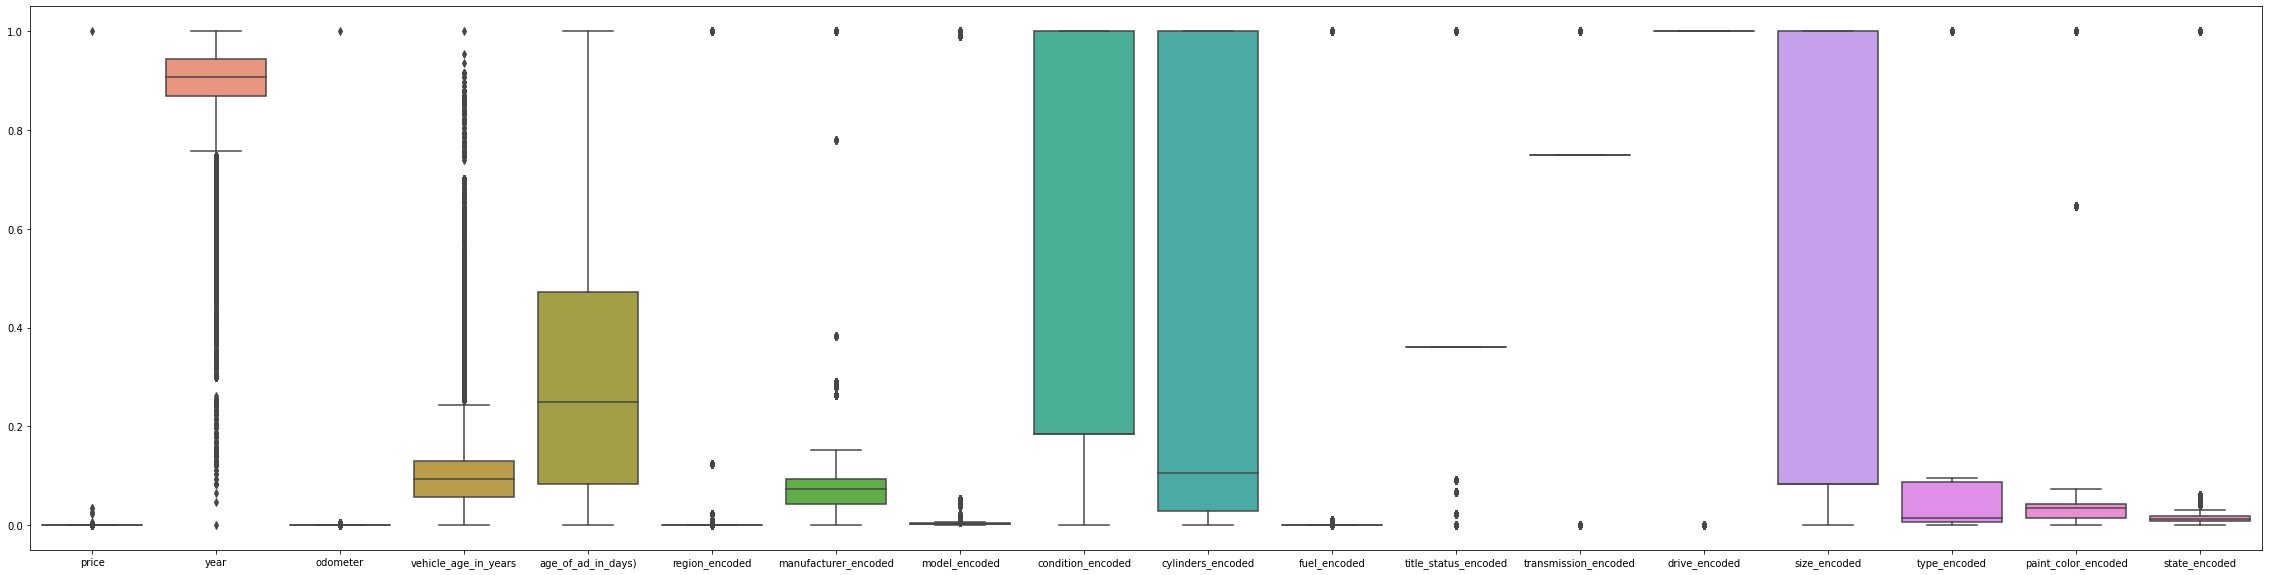

In [ ]:
def visualizeOutlier(scaledData):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(40, 10))
    sns.boxplot(data=scaledData)
visualizeOutlier(scaled_db)

## **IQR Outlier Removal**

In [ ]:
def IQROutlier(data):
    quantile1 = data.quantile(0.25)
    quantile3 = data.quantile(0.75)
    IQR = quantile3 - quantile1
    #print(IQR)
    outlierData = data[~((data < (quantile1 - 1.5 * IQR)) | (data > (quantile3 + 1.5 * IQR))).any(axis=1)]
    print (outlierData.shape)
    
IQROutlier(scaled_db)

(54164, 18)


#**Data Visualization**

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Understanding Year Distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(f"Maximum Year: {df.year.max()} $\nMinimum Year: {df.year.min()} $")

Maximum Year: 2021 $
Minimum Year: 1914 $


In [ ]:
print(f"Number of distinct Vehicles manufactured in 1914: {df[df.year == 1914]['year'].count()}")

Number of distinct Vehicles manufactured in 1914: 1


In [ ]:
print(f"Number of distinct Vehicles manufactured in 2021: {df[df.year == 2021]['year'].count()}")

Number of distinct Vehicles manufactured in 2021: 100


In [ ]:
print(f" Number of distinct vehicles manufactured in between 1914 and 1920: {df[(df.year >= 1914) & (df.year < 1920)]['year'].count()}")
print(f" Number of distinct vehicles manufactured in between 1920 and 1940: {df[(df.year >= 1920) & (df.year < 1940)]['year'].count()}")
print(f" Number of distinct vehicles manufactured in between 1940 and 1960: {df[(df.year >= 1940) & (df.year < 1960)]['year'].count()}")
print(f" Number of distinct vehicles manufactured in between 1960 and 1980: {df[(df.year >= 1960) & (df.year < 1980)]['year'].count()}")

 Number of distinct vehicles manufactured in between 1914 and 1920: 2
 Number of distinct vehicles manufactured in between 1920 and 1940: 178
 Number of distinct vehicles manufactured in between 1940 and 1960: 416
 Number of distinct vehicles manufactured in between 1960 and 1980: 2061


In [ ]:
df[(df.year >= 1914) & (df.year < 1920)]

region  ...  vehicle_age_in_years_bin_label
10807   mohave county  ...                         75-100Q
170397     louisville  ...                         75-100Q

[2 rows x 33 columns]

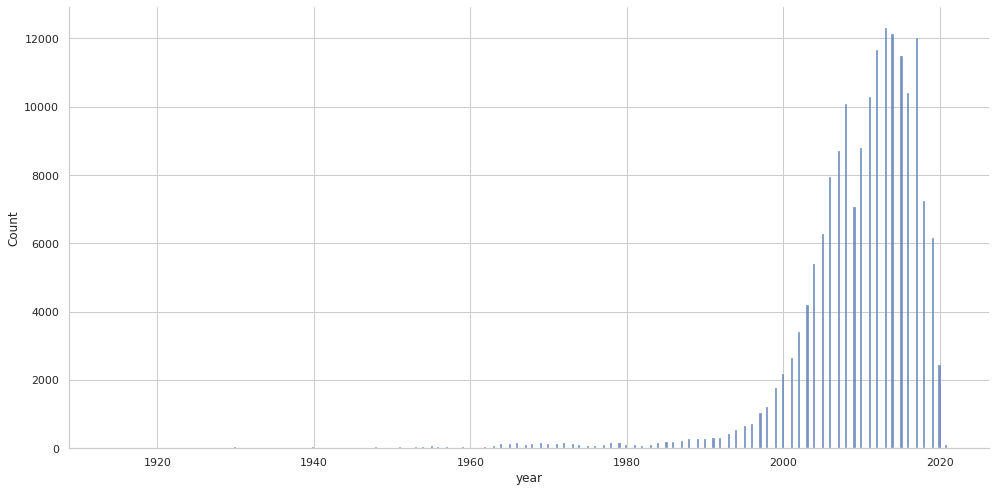

In [ ]:
# Visualizing the count of vehicles manufactured over a period of 100 years
sns.set_theme(style="whitegrid")
sns.displot(df, x='year',height=7, aspect=2)

## Understanding Price Distribution

In [ ]:
print(f"Maximum price: {df.price.max()} $\nMinimum price: {df.price.min()} $")

Maximum price: 3615215112 $
Minimum price: 0 $


In [ ]:
print(f"Number of vehicles listed with zero price: {df[df.price == 0]['price'].count()}")

Number of vehicles listed with zero price: 7844


In [ ]:
print(f"Number of distinct vehicles listed in price range ONE LAKH to TEN LAKHS: {df[(df.price >= 100000) & (df.price < 1000000)]['price'].count()}")
print(f"Number of distinct vehicles listed in price range TEN LAKHS to TEN CRORES: {df[(df.price >= 1000000) & (df.price < 100000000)]['price'].count()}")
print(f"Number of distinct vehicles listed with price above TEN CRORES: {df[(df.price >= 100000000)]['price'].count()}")

Number of distinct vehicles listed in price range ONE LAKH to TEN LAKHS: 79
Number of distinct vehicles listed in price range TEN LAKHS to TEN CRORES: 11
Number of distinct vehicles listed with price above TEN CRORES: 3


As we are having more number of vehicles in the price range of one lakh to ten lakhs, we will be ploting all the vehicles with the price less than Ten Lakhs. If we include the other two ranges it would elongate the graph which would not provide much insight into it.

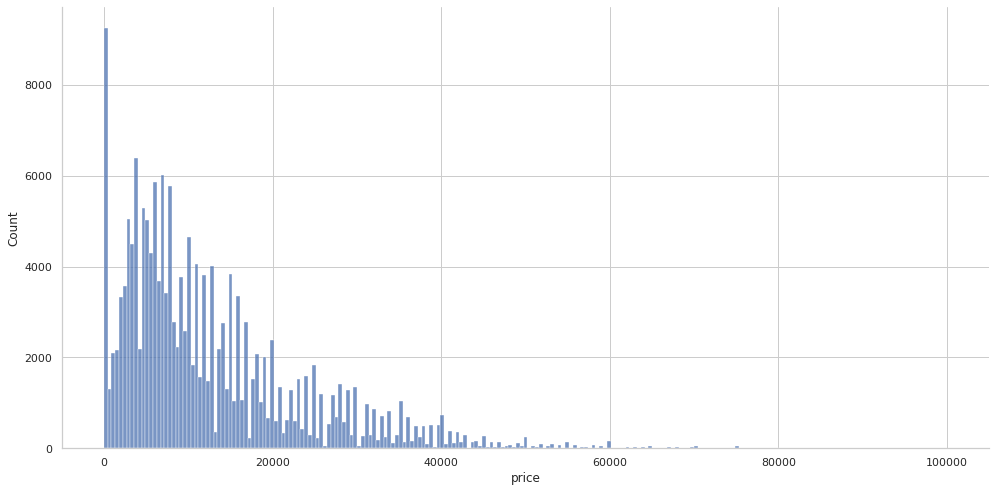

In [ ]:
# Visualizing the count of vehicles vs price
df1=df[df['price'] <= 100000]
sns.set_theme(style="whitegrid")
sns.displot(df1, x='price', height=7, aspect=2)

## Understanding Odometer Reading Distribution

In [ ]:
print(f"Maximum Odometer Reading: {df.odometer.max()} $\nMinimum Odometer Reading: {df.odometer.min()} $")

Maximum Odometer Reading: 2043755555.0 $
Minimum Odometer Reading: 0.0 $


In [ ]:
print(f"Vehicles with odometer reading as zero: {df[df.odometer == 0]['odometer'].count()}")

Vehicles with odometer reading as zero: 486


In [ ]:
print(f"Number of Vehicles with odometer range in between ONE LAKH and FIVE LAKHS: {df[(df.odometer >= 100000) & (df.odometer < 500000)]['odometer'].count()}")
print(f"Number of Vehicles with odometer range in between FIVE LAKH and TEN LAKHS: {df[(df.odometer >= 500000) & (df.odometer < 1000000)]['odometer'].count()}")
print(f"Number of Vehicles with odometer range in between TEN LAKH and TEN CRORES LAKHS: {df[(df.odometer >= 1000000) & (df.odometer < 100000000)]['odometer'].count()}")
print(f"Number of Vehicles with odometer above TEN CRORES: {df[(df.odometer >= 100000000) ]['odometer'].count()}")

Number of Vehicles with odometer range in between ONE LAKH and FIVE LAKHS: 82743
Number of Vehicles with odometer range in between FIVE LAKH and TEN LAKHS: 126
Number of Vehicles with odometer range in between TEN LAKH and TEN CRORES LAKHS: 224
Number of Vehicles with odometer above TEN CRORES: 1


As we are having more number of vehicles in the odometer range of one lakh to five lakhs, we will be ploting all the vehicles with the values less than five Lakhs. If we include the other two ranges it would elongate the graph which would not provide much insight into it.

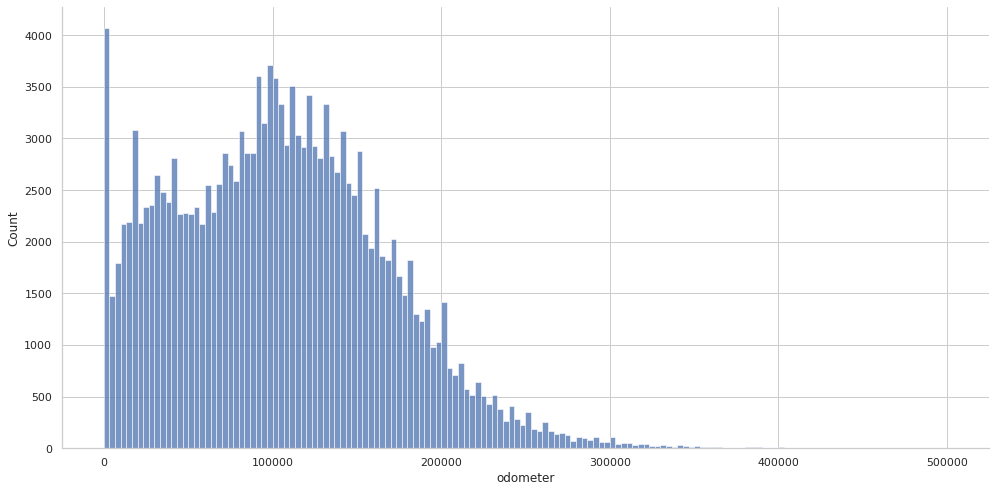

In [ ]:
# Visualizing the Count of vehicles vs Odometer
df1=df1[df1['odometer'] <= 500000]
sns.set_theme(style="whitegrid")
sns.displot(df1, x='odometer', height=7, aspect=2)

## Categorical - Paint Distribution

Vehicles in White color are Most Listed followed by Black & others


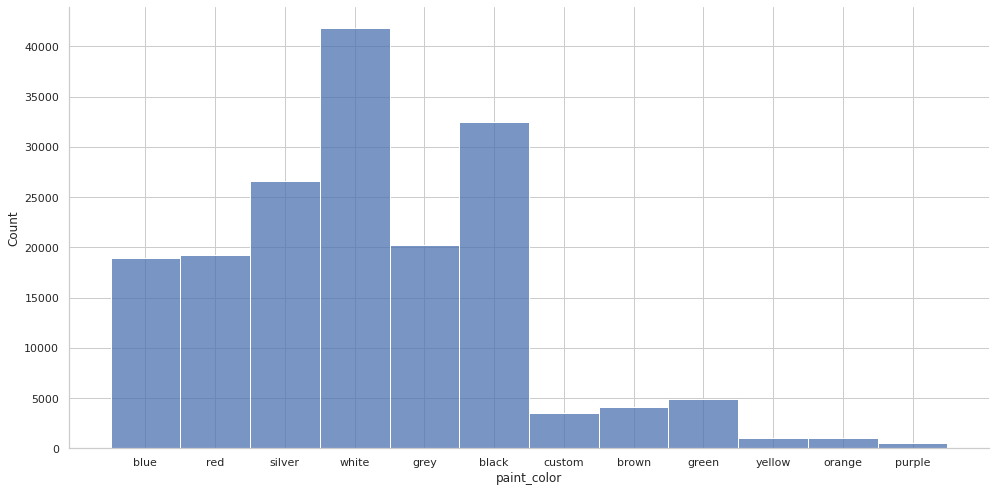

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='paint_color', height=7, aspect=2)

## Categorical - Fuel Distribution

Gasoline Based Vehicles are the Most Listed followed by Diesel & others


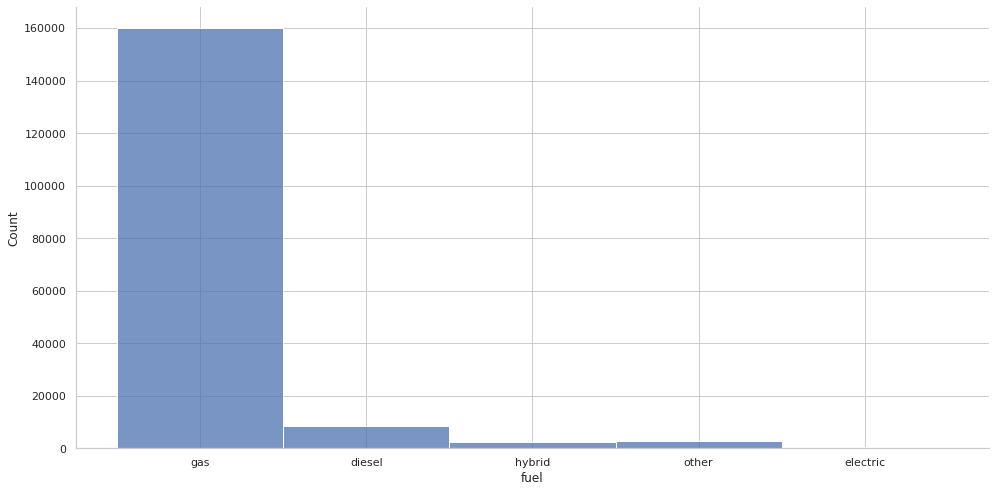

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='fuel', height=7, aspect=2)

In [ ]:
print(f"Number of Electric Vehicles: {df[df.fuel=='electric']['fuel'].count()}")

Number of Electric Vehicles: 611


## Categorical - Drive Distribution


Front Wheel Drive Vehicles are the Most Listed than Rear Wheel Drive




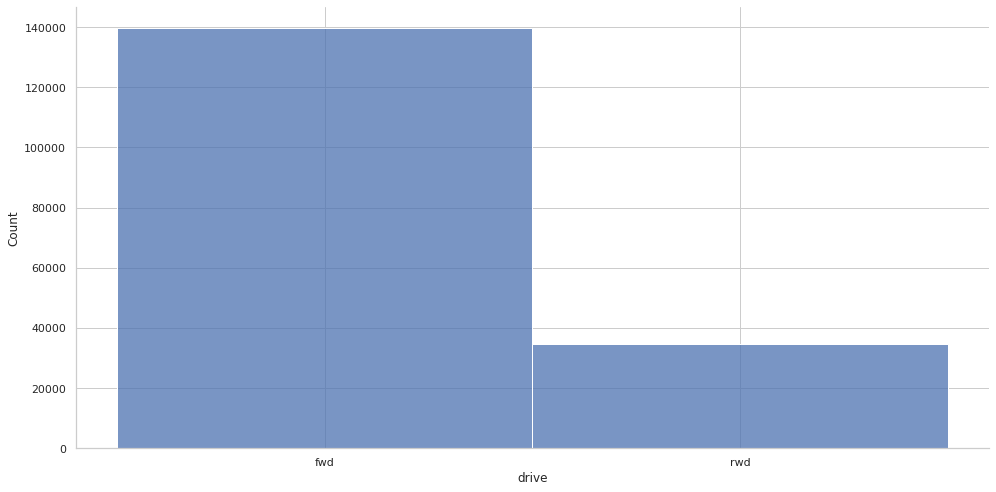

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='drive', height=7, aspect=2)

## Categorical - Condition Distribution


Vehicles with Excellent Condition are listed more than other condition vehicles


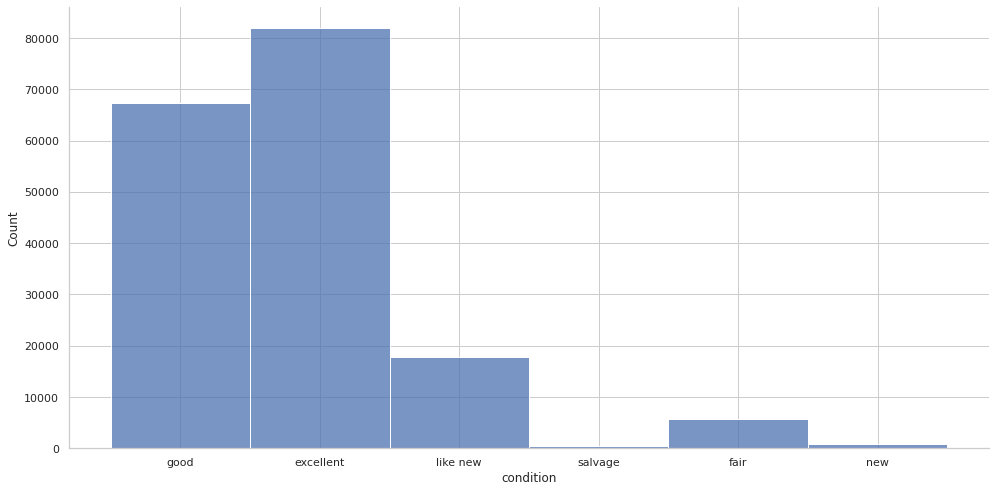

In [ ]:
sns.set_theme(style="whitegrid")
#color_palette = {'Red','Blue','Grey'}
sns.displot(df, x='condition', height=7, aspect=2)

## Categorical - State Distribution


California has listed more vehicles for Resale other state followed by Florida


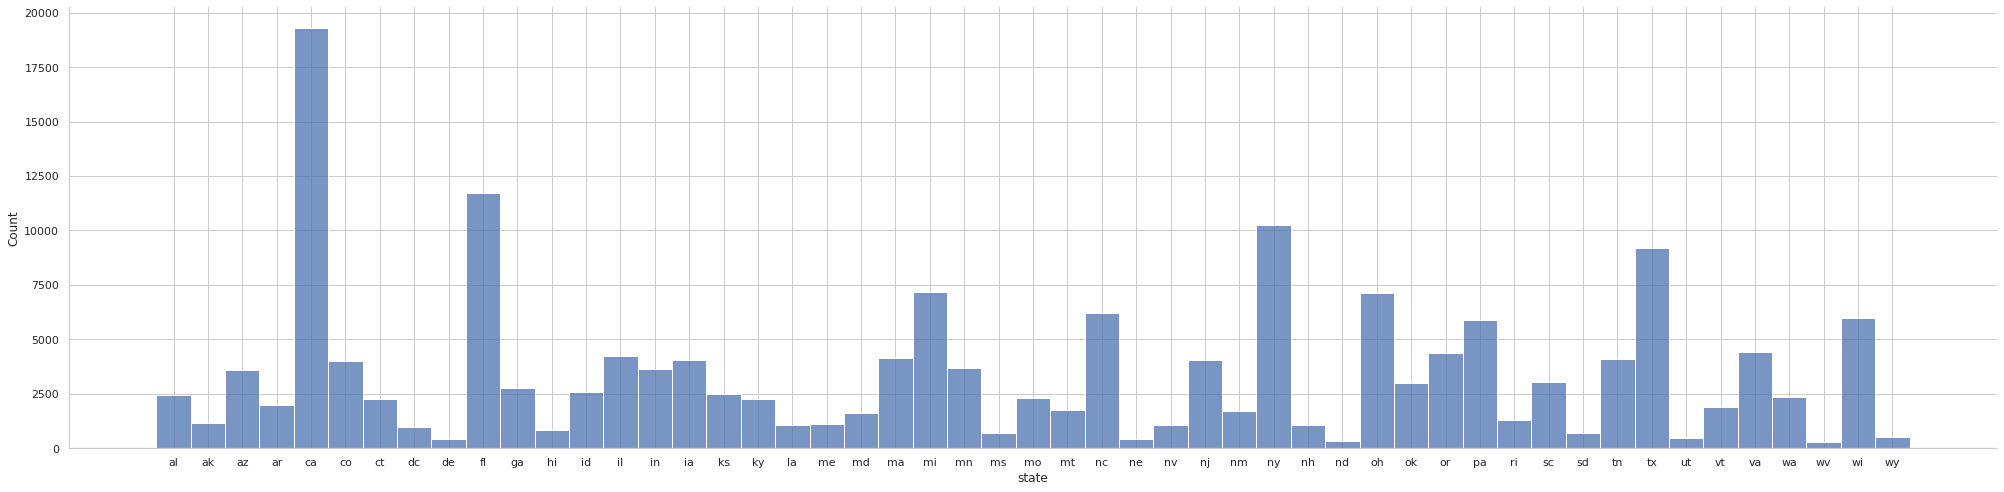

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='state', height=7, aspect=4)

## Categorical - Transmission Distribution


Most of the vehicles listed are Automatic Transmission


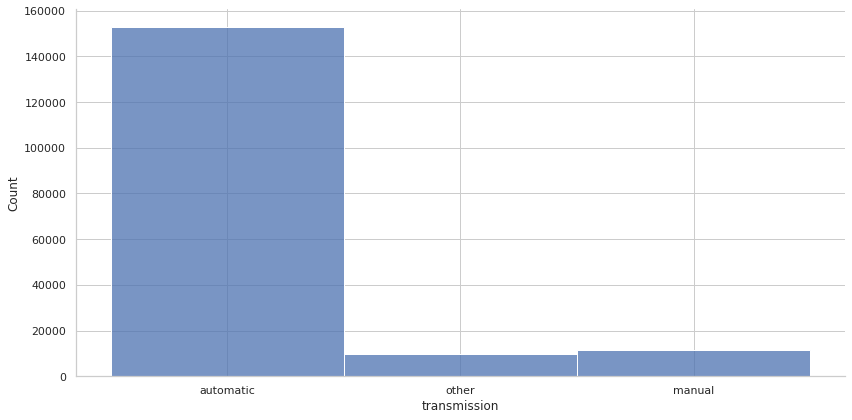

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='transmission', height=6, aspect=2)

## Categorical - Cylinder Distribution



4 & 6 Cylinder Vehicles are most listed and 3 & 12 cylinder vehicles are least listed


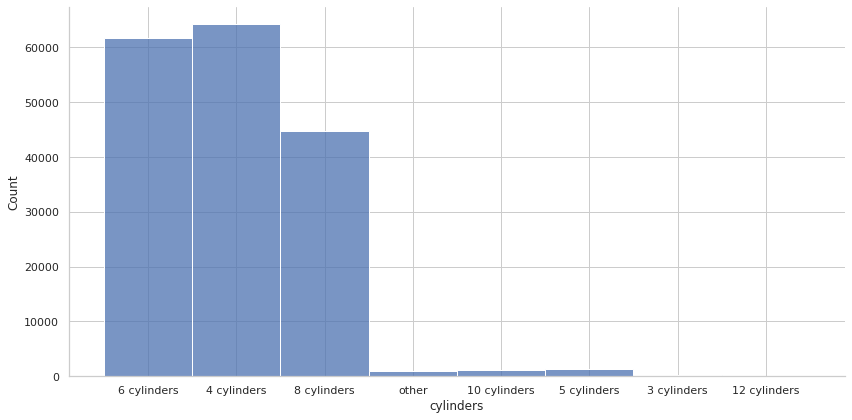

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, x='cylinders', height=6, aspect=2)

## Categorical - Manufacturer Distribution

1.  Ford followed by Chevy are most listed vehicles. Tesla & Fiat are least listed


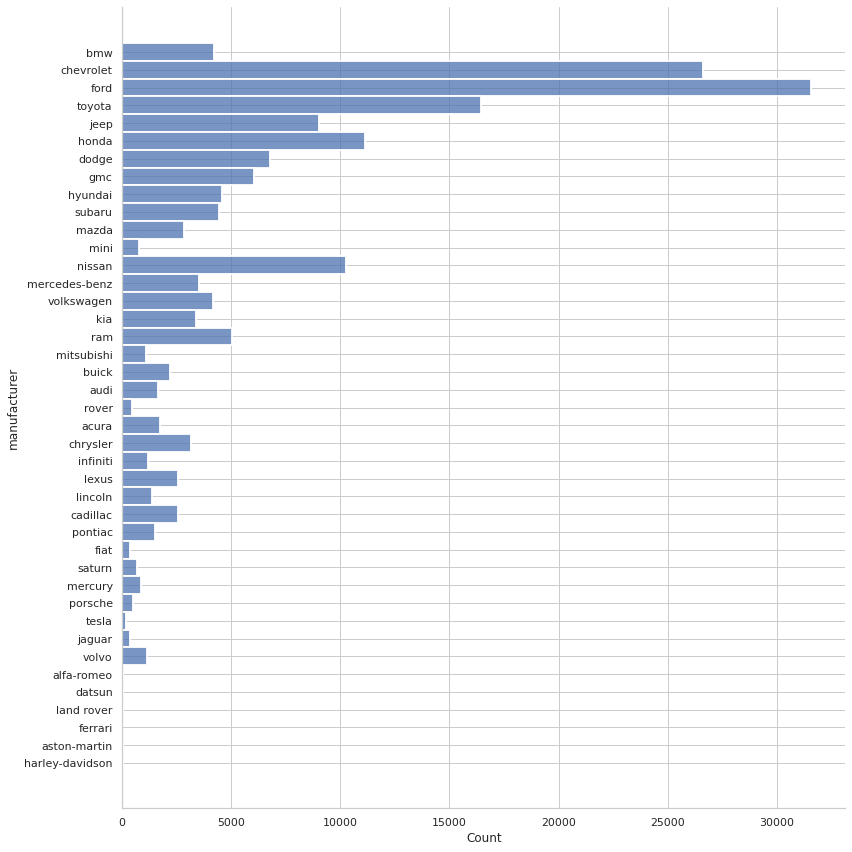

In [ ]:
sns.set_theme(style="whitegrid")
sns.displot(df, y='manufacturer', height=12, aspect=1)

## Average Price vs Manufacturer

Here we are plotting the price of the vehicles less than Ten Lakhs vs Manufacturer.

1.   Average Price of Ferrari,Aston Martin & Tesla are almost 50% more than other Manufacturers Avg price 
2.   Saturn is having the least Priced vehicles for Resale




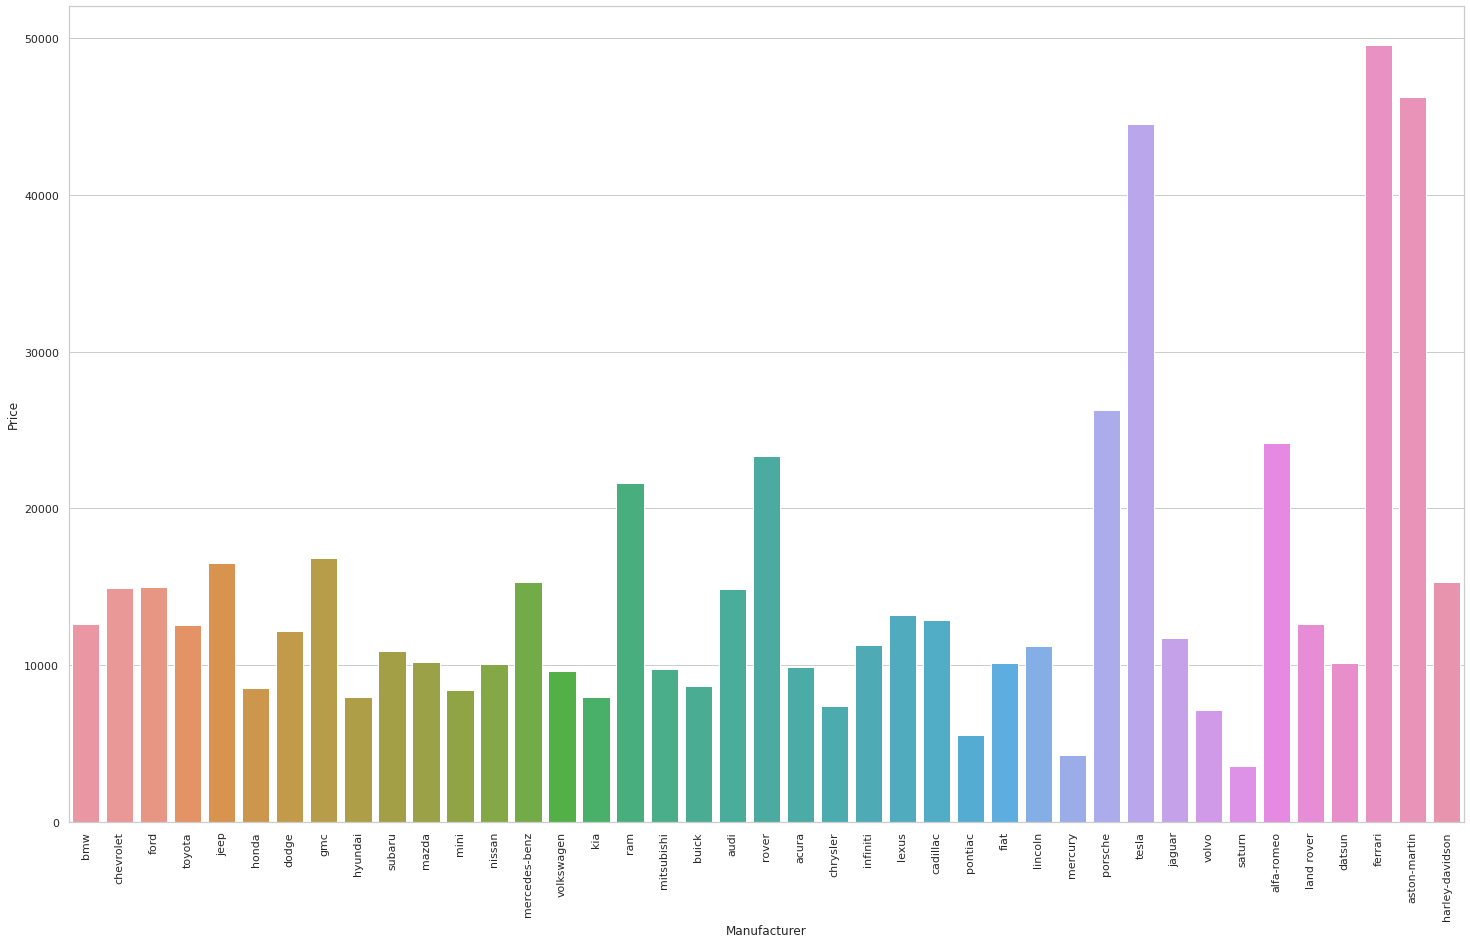

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.manufacturer, y=df1.price,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()

## Average Price vs Paint of the Vehicle

Here we are plotting price of the vehicles less than Ten Lakhs vs Paint color
1.   Interestingly vehicles in Orange are highly priced than White
2.   Vehicles in Black & Red are almost having the same Average Price and are 2nd Highly listed



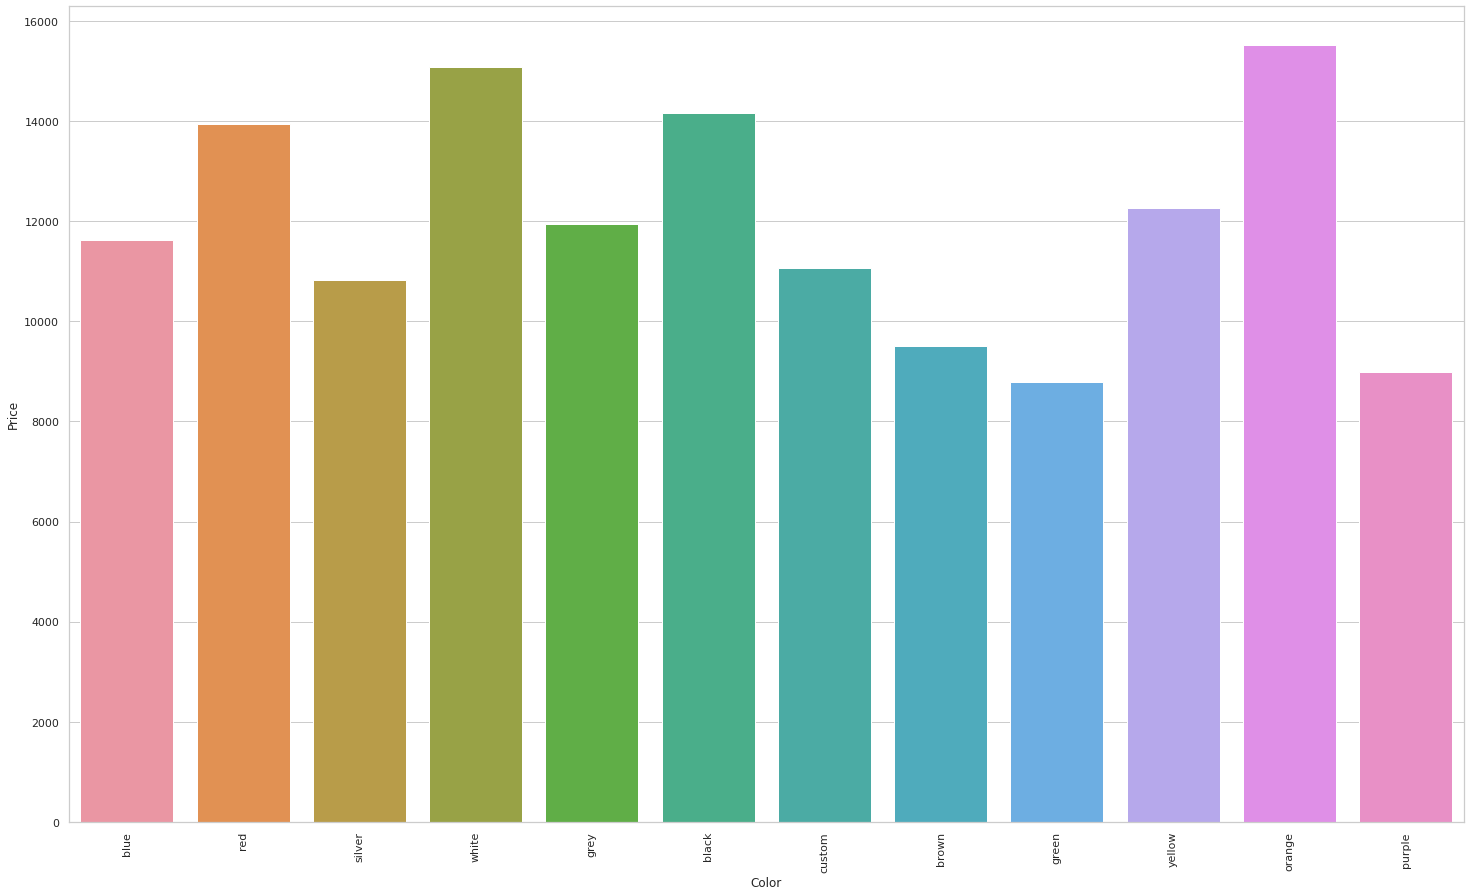

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.paint_color, y=df1.price,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('Color')
plt.ylabel('Price')
plt.show()

## Average Price vs Vehicle Condition

Here we are plotting price of the vehicles less than Ten lakhs vs Condition of the vehicle
1.   Even though New condition vehicle's Average Price is higher than any others "Excellent" & "Good" are more or less are listed in same price range



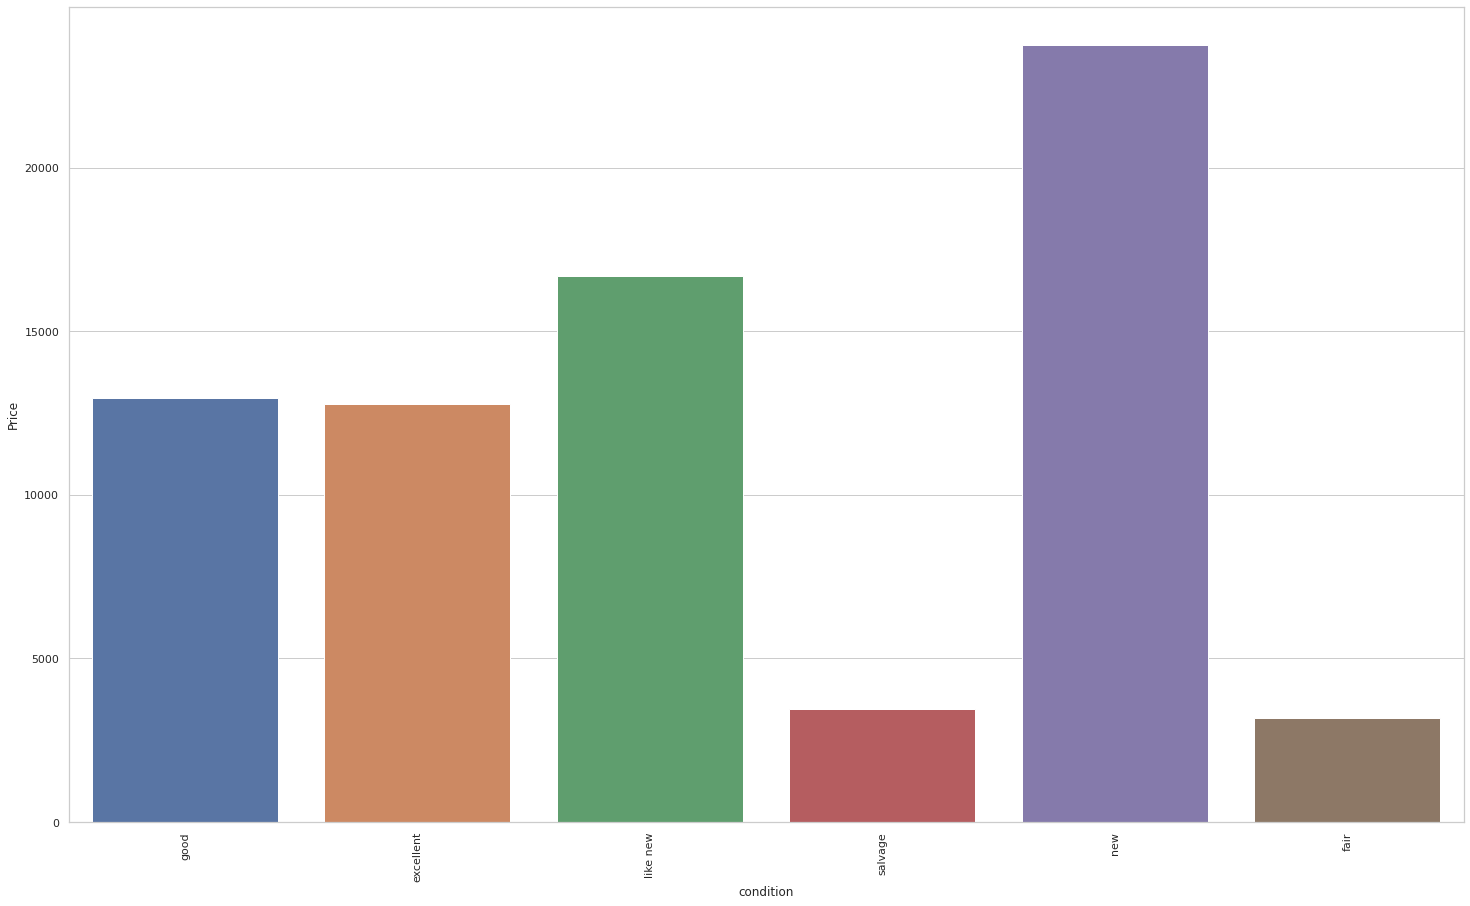

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.condition, y=df1.price,ci=None,)
plt.xticks(rotation= 90)
plt.xlabel('condition')
plt.ylabel('Price')
plt.show()

## Average Price vs State

Here, we are plotting price of the vehicles less than Ten Lakhs vs state

1.   Even though Wyoming State have very less cars listed for Resale the Average Price is Very high. Which is kind of Anamoly



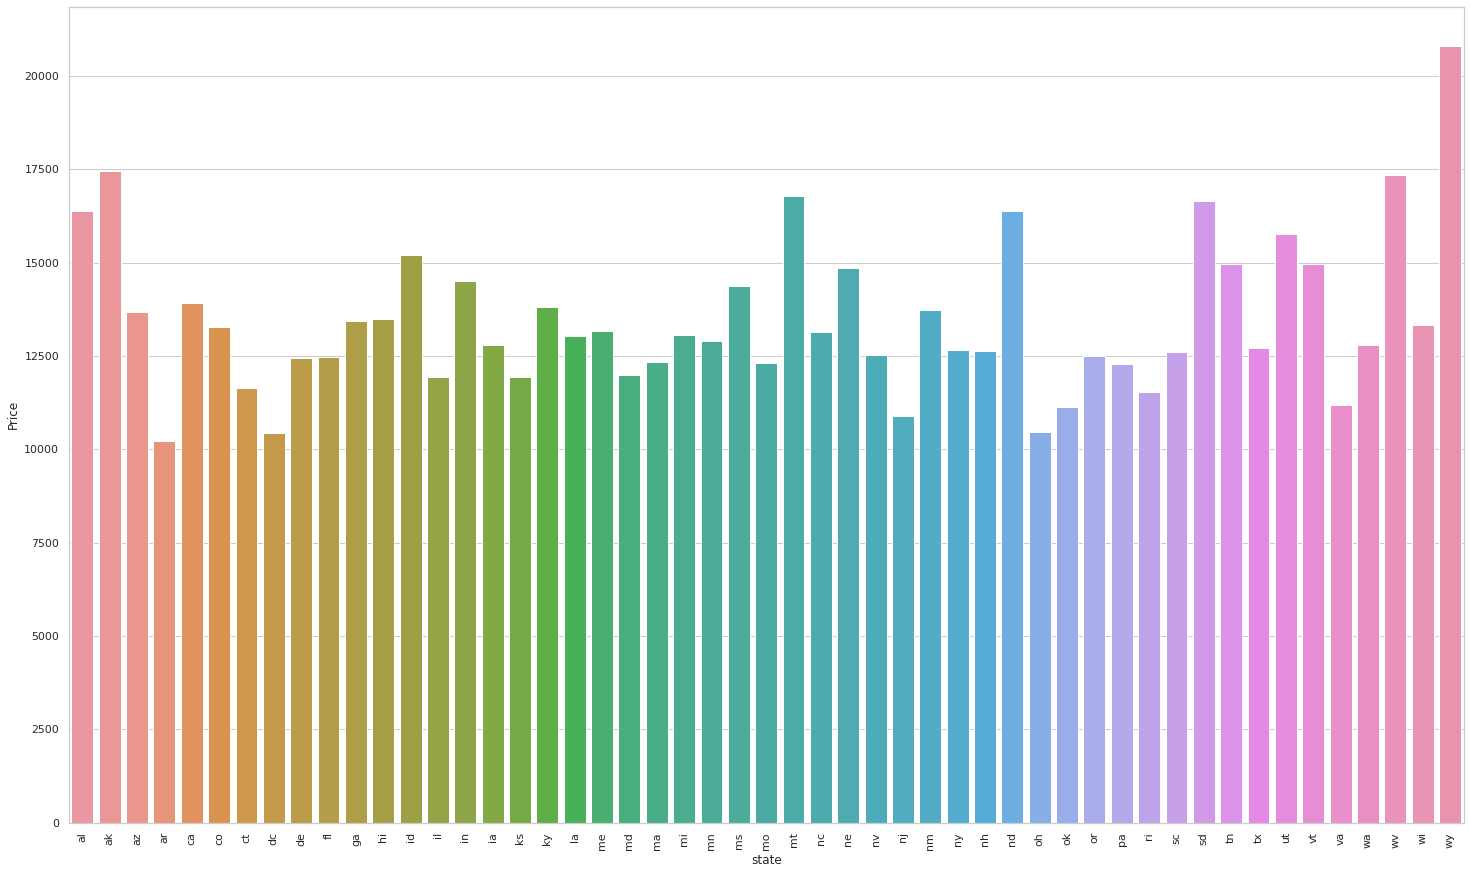

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.state, y=df1.price,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('state')
plt.ylabel('Price')
plt.show()

## Average Price Vs Type

Here, we are plotting price of the vehicles less than ten lakhs vs type of vehicles

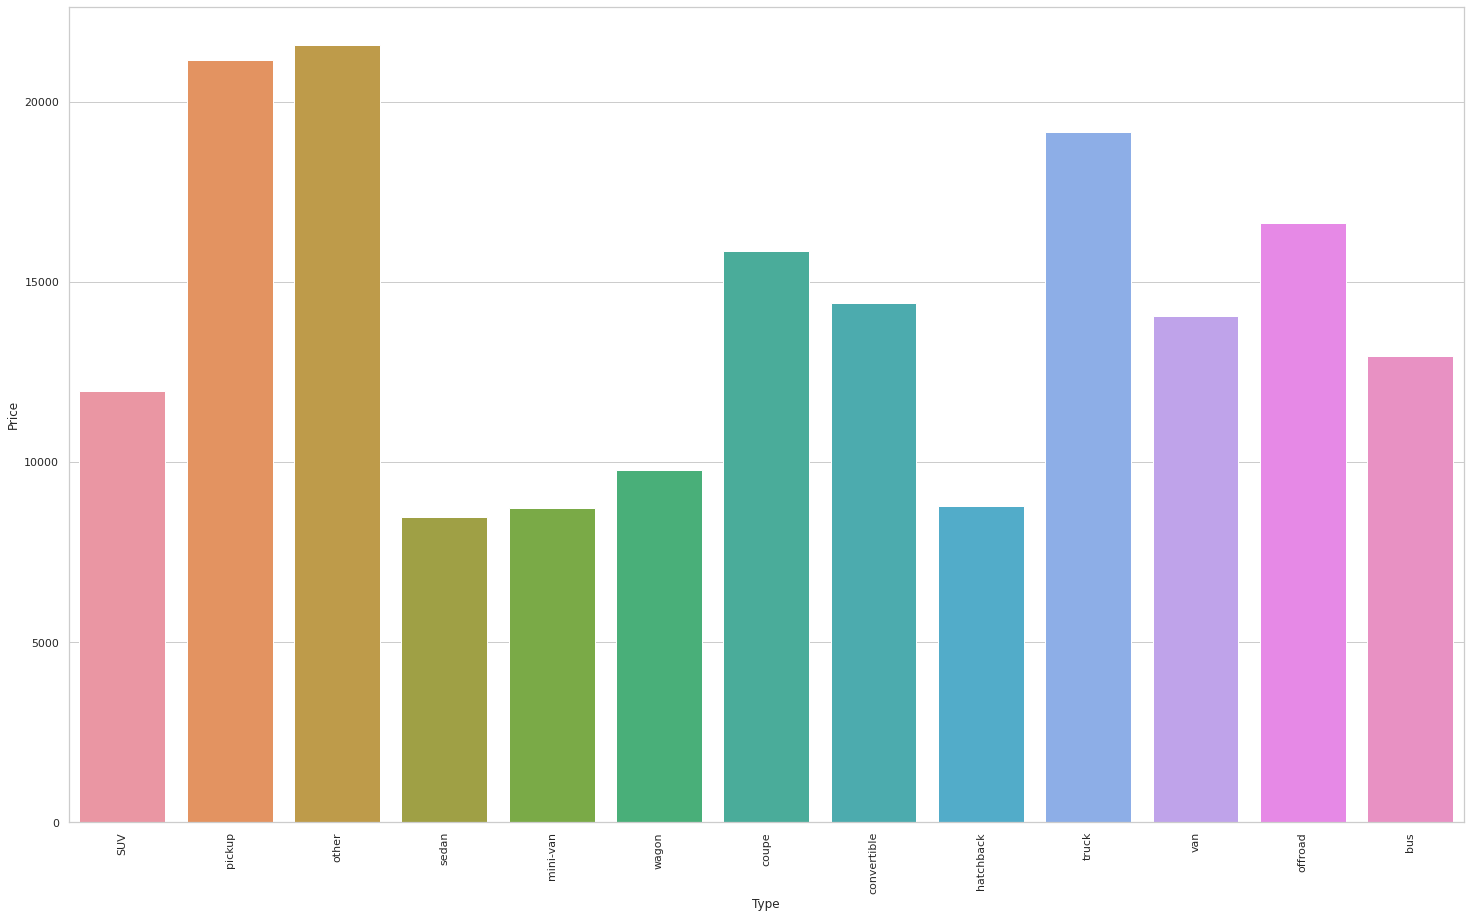

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.type, y=df1.price,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('Type')
plt.ylabel('Price')
plt.show()

## AVerage Odometer Reading vs Manufacturer

Here, the plot depicts the odometer values less than five lakhs vs Manufacturer

1.   Interestingly Cars Manufacturer like Saturn,Volvo,Mercury are having more Odometer readings in the listing than usual Honda,Nissan & Ford



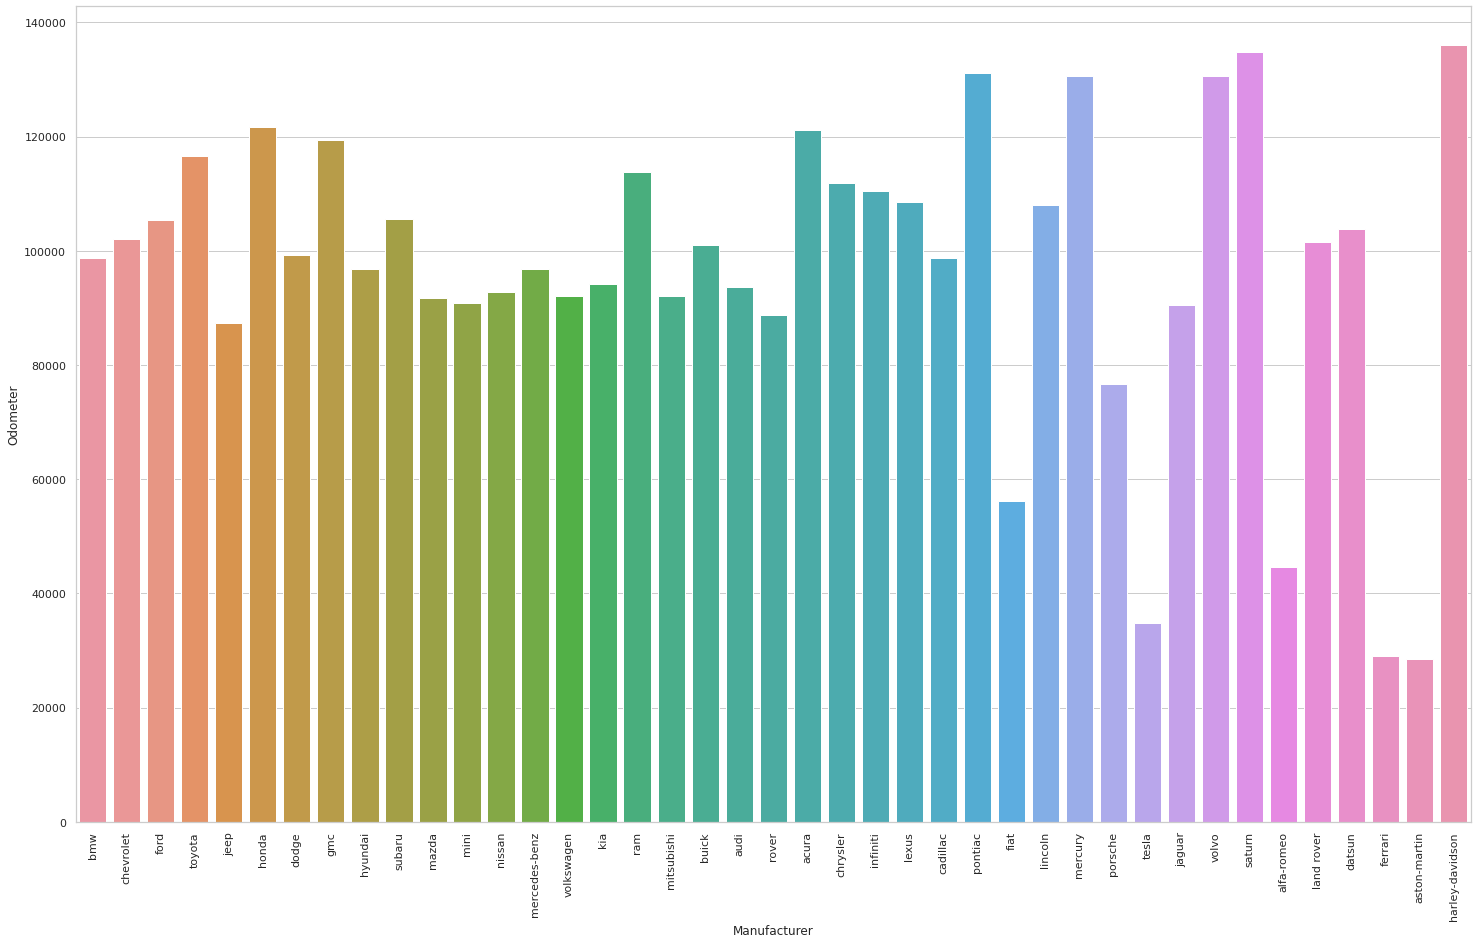

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df1.manufacturer, y=df1.odometer,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer')
plt.ylabel('Odometer')
plt.show()

## Type vs Age of Vehicle
 

1. Average Age of Convertible & Offroad vehicles are greater than other Vehicle types

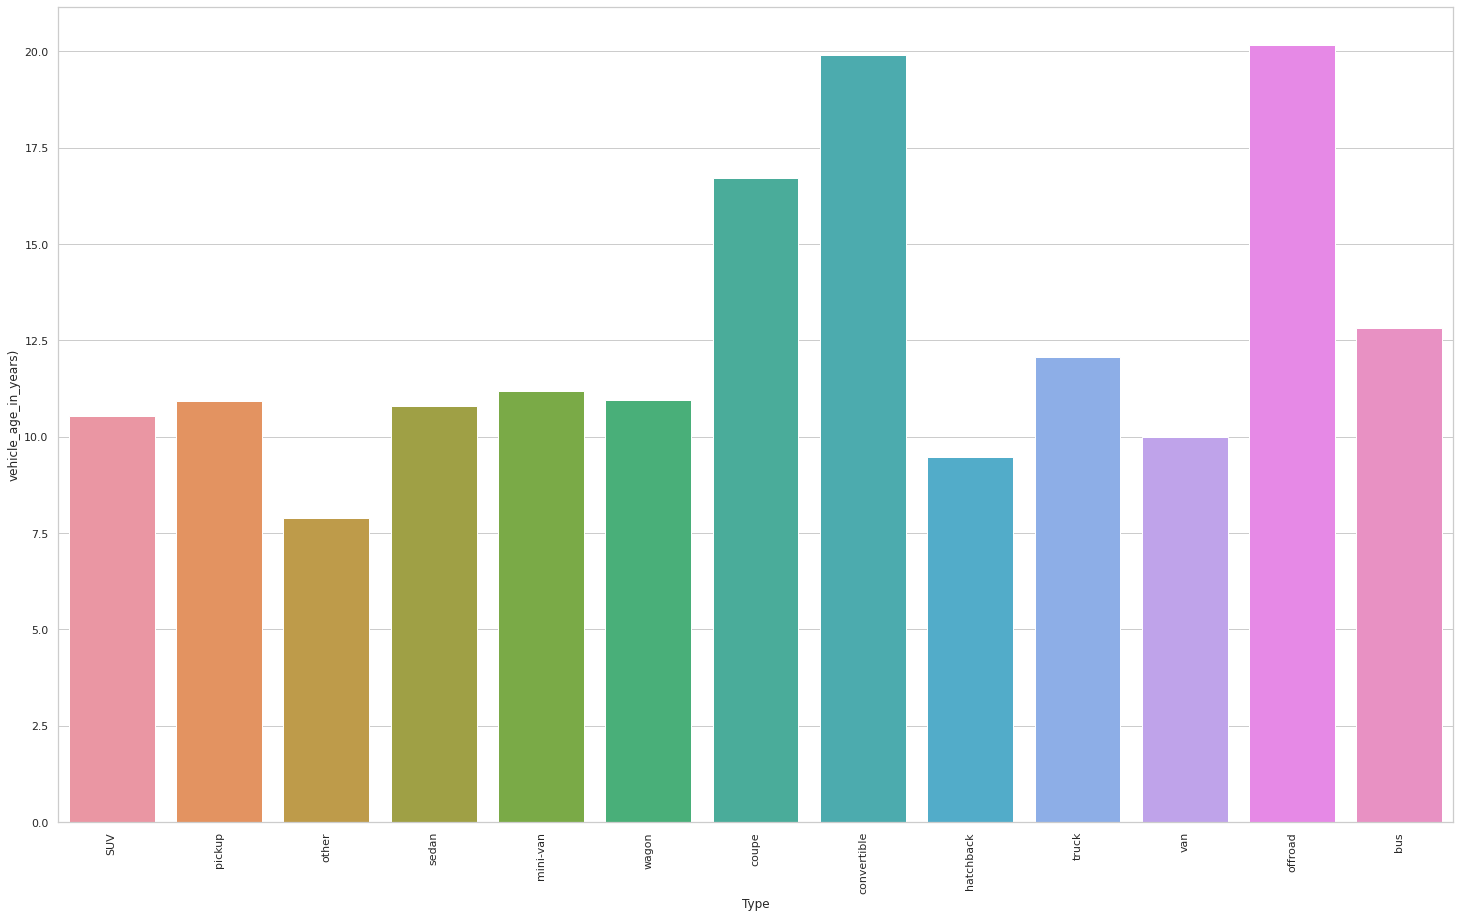

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x=df.type, y=df.vehicle_age_in_years,ci=None)
plt.xticks(rotation= 90)
plt.xlabel('Type')
plt.ylabel('vehicle_age_in_years)')
plt.show()

## Pair Plot - Comparison of Numerical Columns

CPU times: user 31min 7s, sys: 16.8 s, total: 31min 24s
Wall time: 31min 6s


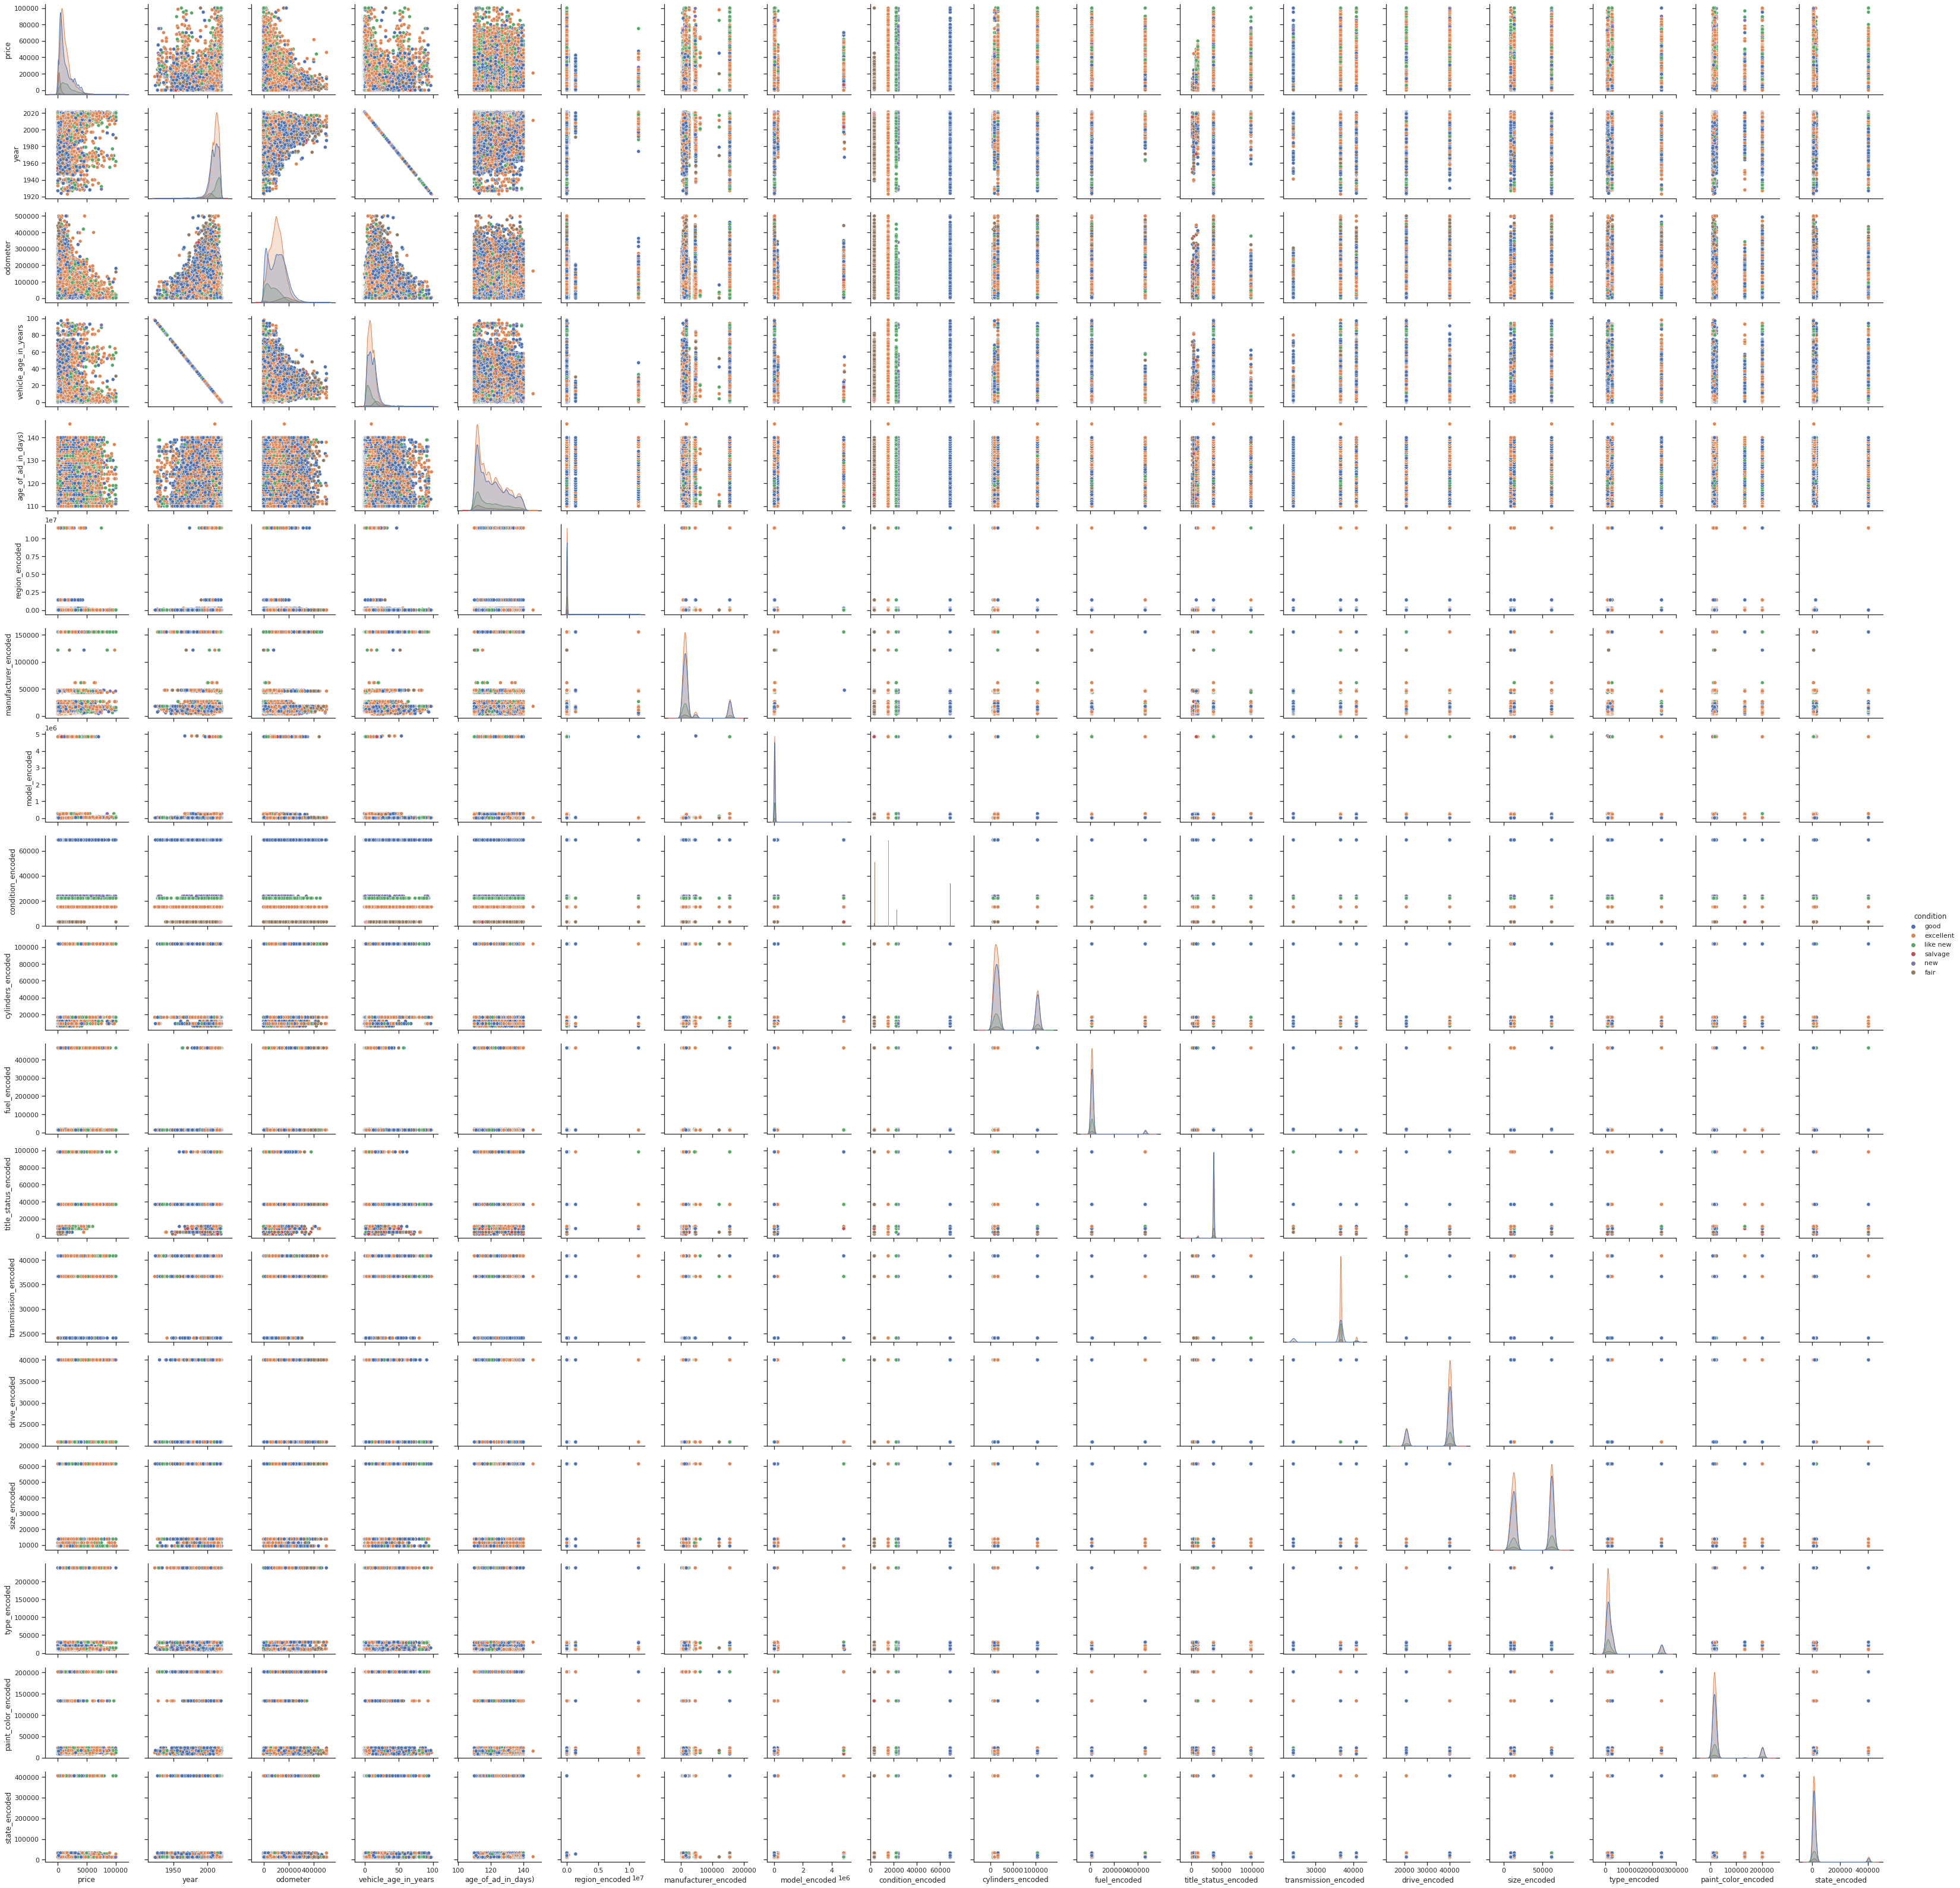

In [ ]:
%%time
sns.set(style="ticks", color_codes=True)
sns.pairplot(df1, hue="condition");

#25 Most Popular Vehicles for Sale

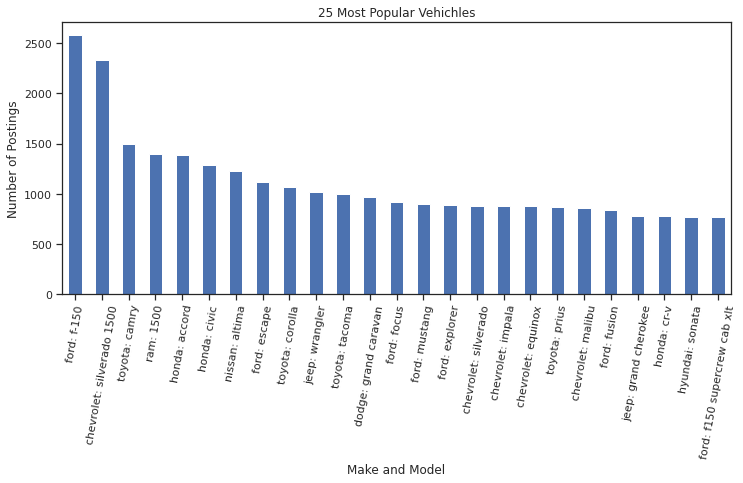

In [ ]:
df1['make_model'] = df1['manufacturer'] + ': ' + df1['model'] #add a column with the make and model in one string (for plotting)
com_cars = df1.make_model.value_counts()[:25]#the 25 most popular cars

#plot the results
fig = com_cars.plot.bar(figsize=(12,5))
plt.xlabel('Make and Model')
plt.ylabel('Number of Postings')
plt.title('25 Most Popular Vehichles')
plt.xticks(rotation=80)
plt.show()

#Average Price of 25 Most Popular Vehicles for Sale

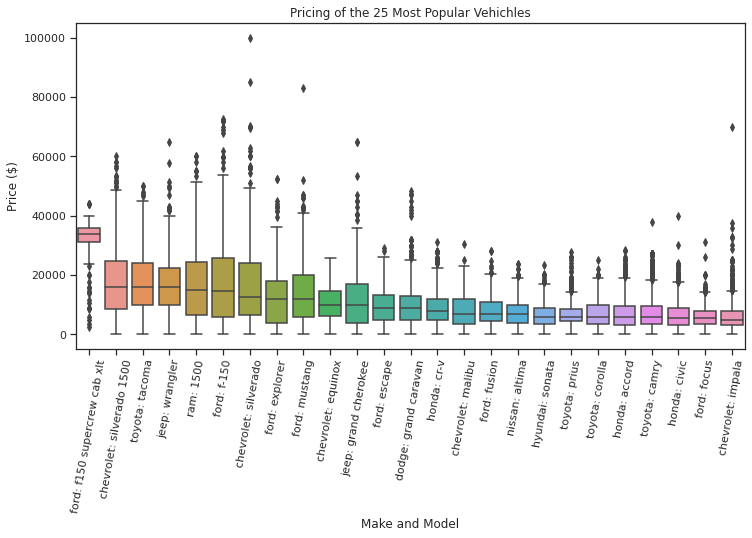

In [ ]:
#plot the average prices of the 25 most popular cars
com_price = df1.loc[df1.make_model.isin(com_cars.index)]
ordered_labels = com_price.groupby('make_model').price.median().sort_values(ascending=False).index.values

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=com_price, x="make_model", y="price", order=ordered_labels, ax=ax)
plt.xticks(rotation = 80)
plt.xlabel('Make and Model')
plt.ylabel('Price ($)')
plt.title('Pricing of the 25 Most Popular Vehichles')
plt.show()

## **Model Metrics**

In [16]:
pd.read_csv('metrics_dbscan.csv', index_col= 0)

Model                 Techniques  ...       MSE       MAE
0           ridge     All Feature without CV  ...  0.010425  0.070277
1           ridge  Randomized Search with CV  ...  0.010425  0.070277
2           ridge          Cross val with CV  ...  0.010547  0.070412
3             sgd     All Feature without CV  ...  0.035792  0.148281
4             sgd  Randomized Search with CV  ...  0.010488  0.070927
5             sgd          Cross val with CV  ...  0.011538  0.075121
6          mlp-nn     All Feature without CV  ...  0.006066  0.051404
7          mlp-nn  Randomized Search with CV  ...  0.008874  0.060815
8          mlp-nn          Cross val with CV  ...  0.009861  0.066061
9             gbm     All Feature without CV  ...  0.006340  0.052015
10            gbm  Randomized Search with CV  ...  0.006283  0.050402
11            gbm          Cross val with CV  ...  0.006774  0.052458
12            gbm                RFE with CV  ...  0.006151  0.049546
13            xgb     All Feature without CV  ...  0.005990  0.050261
14            xgb  Randomized Search with CV  ...  0.005078  0.046027
15            xgb          Cross val with CV  ...  0.007102  0.054414
16            xgb                RFE with CV  ...  0.004998  0.045234
17        bagging     All Feature without CV  ...  0.004614  0.039975
18        bagging  Randomized Search with CV  ...  0.005609  0.049463
19        bagging          Cross val with CV  ...  0.007793  0.059419
20      ada boost     All Feature without CV  ...  0.012747  0.082281
21      ada boost  Randomized Search with CV  ...  0.011650  0.076879
22      ada boost          Cross val with CV  ...  0.011451  0.075967
23            DTC     All Feature without CV  ...  0.008807  0.052854
24            DTC  Randomized Search with CV  ...  0.029174  0.130111
25            DTC          Cross val with CV  ...  0.027754  0.126792
26            knn     All Feature without CV  ...  0.008237  0.057765
27  random forest     All Feature without CV  ...  0.009569  0.065512

[28 rows x 7 columns]

In [15]:
pd.read_csv('metrics_zscore.csv', index_col= 0 )

Model                 Techniques  ...       MSE       MAE
0           ridge     All Feature without CV  ...  0.013651  0.081266
1           ridge  Randomized Search with CV  ...  0.013652  0.081267
2           ridge          Cross val with CV  ...  0.013886  0.081591
3             sgd     All Feature without CV  ...  0.043192  0.170141
4             sgd  Randomized Search with CV  ...  0.013661  0.081257
5             sgd          Cross val with CV  ...  0.014944  0.086435
6          mlp-nn     All Feature without CV  ...  0.007836  0.058272
7          mlp-nn  Randomized Search with CV  ...  0.012106  0.073329
8          mlp-nn          Cross val with CV  ...  0.013255  0.077385
9             gbm     All Feature without CV  ...  0.008146  0.058632
10            gbm  Randomized Search with CV  ...  0.008055  0.057017
11            gbm          Cross val with CV  ...  0.009032  0.059965
12            gbm                RFE with CV  ...  0.008002  0.056725
13            xgb     All Feature without CV  ...  0.007700  0.056724
14            xgb  Randomized Search with CV  ...  0.006445  0.051415
15            xgb          Cross val with CV  ...  0.009477  0.063216
16            xgb                RFE with CV  ...  0.006389  0.051009
17        bagging     All Feature without CV  ...  0.005939  0.044786
18        bagging  Randomized Search with CV  ...  0.007422  0.057463
19        bagging          Cross val with CV  ...  0.010304  0.069199
20      ada boost     All Feature without CV  ...  0.015457  0.093379
21      ada boost  Randomized Search with CV  ...  0.014372  0.086313
22      ada boost          Cross val with CV  ...  0.014573  0.086646
23            DTC     All Feature without CV  ...  0.010973  0.058549
24            DTC  Randomized Search with CV  ...  0.025999  0.119063
25            DTC          Cross val with CV  ...  0.037258  0.147076
26            knn     All Feature without CV  ...  0.010522  0.064410
27  random forest     All Feature without CV  ...  0.011783  0.072255

[28 rows x 7 columns]

In [14]:
pd.read_csv('metrics_outliers.csv', index_col= 0)

Model                 Techniques  ...       MSE       MAE
0           ridge     All Feature without CV  ...  0.011121  0.072393
1           ridge  Randomized Search with CV  ...  0.011121  0.072393
2           ridge          Cross val with CV  ...  0.011251  0.072424
3             sgd     All Feature without CV  ...  0.036118  0.149815
4             sgd  Randomized Search with CV  ...  0.011141  0.072524
5             sgd          Cross val with CV  ...  0.012123  0.076503
6          mlp-nn     All Feature without CV  ...  0.006708  0.054145
7          mlp-nn  Randomized Search with CV  ...  0.009653  0.064736
8          mlp-nn          Cross val with CV  ...  0.010590  0.067756
9             gbm     All Feature without CV  ...  0.006858  0.053502
10            gbm  Randomized Search with CV  ...  0.006668  0.051565
11            gbm          Cross val with CV  ...  0.007213  0.053691
12            gbm                RFE with CV  ...  0.006606  0.051607
13            xgb     All Feature without CV  ...  0.006509  0.051890
14            xgb  Randomized Search with CV  ...  0.005423  0.046729
15            xgb          Cross val with CV  ...  0.007660  0.056249
16            xgb                RFE with CV  ...  0.005351  0.046169
17        bagging     All Feature without CV  ...  0.005113  0.041622
18        bagging  Randomized Search with CV  ...  0.006522  0.053679
19        bagging          Cross val with CV  ...  0.008383  0.061232
20      ada boost     All Feature without CV  ...  0.014082  0.088753
21      ada boost  Randomized Search with CV  ...  0.012382  0.079173
22      ada boost          Cross val with CV  ...  0.012081  0.077716
23            DTC     All Feature without CV  ...  0.009547  0.054824
24            DTC  Randomized Search with CV  ...  0.027025  0.125339
25            DTC          Cross val with CV  ...  0.024696  0.116544
26            knn     All Feature without CV  ...  0.008942  0.059644
27  random forest     All Feature without CV  ...  0.010085  0.066931

[28 rows x 7 columns]